In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import matplotlib

from numba import jit, double

from utils.printing_utils_3 import plot

%matplotlib inline

In [2]:
@jit(nopython=True)
def normalize(obj):
    
    return obj / np.linalg.norm(obj)

@jit(nopython=True)
def skew_symm(vec):
        
    return np.array([[0., -vec[2], vec[1]],[vec[2], 0., -vec[0]],[-vec[1], vec[0], 0.]])

@jit(nopython=True)
def cross(vec1, vec2):
    
    a1, a2, a3 = double(vec1[0]), double(vec1[1]), double(vec1[2])
    b1, b2, b3 = double(vec2[0]), double(vec2[1]), double(vec2[2])
    
    return np.array([a2 * b3 - a3 * b2, a3 * b1 - a1 * b3, a1 * b2 - a2 * b1])

@jit(nopython=True)
def dot_ab(vec1, vec2):
    
    a1, a2, a3 = double(vec1[0]), double(vec1[1]), double(vec1[2])
    b1, b2, b3 = double(vec2[0]), double(vec2[1]), double(vec2[2])
    
    return a1*b1 + a2*b2 + a3*b3

@jit(nopython=True)
def dot_Ab(arr, vec):
    
    a11, a12, a13 = double(arr[0,0]), double(arr[0,1]), double(arr[0,2])
    a21, a22, a23 = double(arr[1,0]), double(arr[1,1]), double(arr[1,2])
    a31, a32, a33 = double(arr[2,0]), double(arr[2,1]), double(arr[2,2])
    b1, b2, b3 = double(vec[0]), double(vec[1]), double(vec[2])
    
    return np.array([a11*b1 + a12*b2 + a13*b3, a21*b1 + a22*b2 + a23*b3, a31*b1 + a32*b2 + a33*b3])

@jit(nopython=True)
def quat_product(q1, q2):
    
    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - dot_ab(q1[1:], q2[1:])
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + cross(q1[1:], q2[1:])
    
    return q

@jit(nopython=True)
def rot_q(q, vec, passive=True):
    
    sign = (passive * (-1.) + (not passive) * 1.)
    
    qxvec = cross(q[1:], vec)
    
    return dot_ab(q[1:], vec) * q[1:] + q[0]**2. * vec + cross(q[1:], qxvec) + 2. * q[0] * qxvec * sign

@jit(nopython=True)
def quat2rpy(quat):
    
    q0, q1, q2, q3 = quat[0], quat[1], quat[2], quat[3]
    
    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))
    
    return np.vstack((roll, pitch, yaw))

@jit(nopython=True)
def quat_conjugate(q):
    
    q_new = np.copy(q)
    q_new[1:] *= -1.
    
    return q_new

@jit(nopython=True)
def ndarray_to_nx1(vec):
    
    return vec.reshape(-1,1)

@jit(nopython=True)
def nx1_to_ndarray(vec):
    
    return vec.reshape(-1)

@jit(nopython=True)
def normal(bias, std):
    
    b1, b2, b3 = double(bias[0]), double(bias[1]), double(bias[2])
    std = double(std)
    
    return np.array([np.random.normal(b1, std), np.random.normal(b2, std), np.random.normal(b3, std)])

@jit(nopython=True)
def inv_3x3(arr):
    
    arr_inv = np.linalg.inv(arr)
    a11, a12, a13 = double(arr_inv[0,0]), double(arr_inv[0,1]), double(arr_inv[0,2])
    a21, a22, a23 = double(arr_inv[1,0]), double(arr_inv[1,1]), double(arr_inv[1,2])
    a31, a32, a33 = double(arr_inv[2,0]), double(arr_inv[2,1]), double(arr_inv[2,2])
    
    return np.array([[a11, a12, a13],
                     [a21, a22, a23],
                     [a31, a32, a33]])

@jit(nopython=True)
def inv_6x6(arr):
    
    arr_inv = np.linalg.inv(arr)
    a11, a12, a13, a14, a15, a16 = double(arr_inv[0,0]), double(arr_inv[0,1]), double(arr_inv[0,2]), \
                                   double(arr_inv[0,3]), double(arr_inv[0,4]), double(arr_inv[0,5])
    a21, a22, a23, a24, a25, a26 = double(arr_inv[1,0]), double(arr_inv[1,1]), double(arr_inv[1,2]), \
                                   double(arr_inv[1,3]), double(arr_inv[1,4]), double(arr_inv[1,5])
    a31, a32, a33, a34, a35, a36 = double(arr_inv[2,0]), double(arr_inv[2,1]), double(arr_inv[2,2]), \
                                   double(arr_inv[2,3]), double(arr_inv[2,4]), double(arr_inv[2,5])
    a41, a42, a43, a44, a45, a46 = double(arr_inv[3,0]), double(arr_inv[3,1]), double(arr_inv[3,2]), \
                                   double(arr_inv[3,3]), double(arr_inv[3,4]), double(arr_inv[3,5])
    a51, a52, a53, a54, a55, a56 = double(arr_inv[4,0]), double(arr_inv[4,1]), double(arr_inv[4,2]), \
                                   double(arr_inv[4,3]), double(arr_inv[4,4]), double(arr_inv[4,5])
    a61, a62, a63, a64, a65, a66 = double(arr_inv[5,0]), double(arr_inv[5,1]), double(arr_inv[5,2]), \
                                   double(arr_inv[5,3]), double(arr_inv[5,4]), double(arr_inv[5,5])
    
    return np.array([[a11, a12, a13, a14, a15, a16],
                     [a21, a22, a23, a24, a25, a26],
                     [a31, a32, a33, a34, a35, a36],
                     [a41, a42, a43, a44, a45, a46],
                     [a51, a52, a53, a54, a55, a56],
                     [a61, a62, a63, a64, a65, a66]])

@jit(nopython=True)
def inv_9x9(arr):
    
    arr_inv = np.linalg.inv(arr)
    a11, a12, a13, a14, a15, a16, a17, a18, a19 = double(arr_inv[0,0]), double(arr_inv[0,1]), double(arr_inv[0,2]), \
                                                  double(arr_inv[0,3]), double(arr_inv[0,4]), double(arr_inv[0,5]), \
                                                  double(arr_inv[0,6]), double(arr_inv[0,7]), double(arr_inv[0,8])
    a21, a22, a23, a24, a25, a26, a27, a28, a29 = double(arr_inv[1,0]), double(arr_inv[1,1]), double(arr_inv[1,2]), \
                                                  double(arr_inv[1,3]), double(arr_inv[1,4]), double(arr_inv[1,5]), \
                                                  double(arr_inv[1,6]), double(arr_inv[1,7]), double(arr_inv[1,8])
    a31, a32, a33, a34, a35, a36, a37, a38, a39 = double(arr_inv[2,0]), double(arr_inv[2,1]), double(arr_inv[2,2]), \
                                                  double(arr_inv[2,3]), double(arr_inv[2,4]), double(arr_inv[2,5]), \
                                                  double(arr_inv[2,6]), double(arr_inv[2,7]), double(arr_inv[2,8])
    a41, a42, a43, a44, a45, a46, a47, a48, a49 = double(arr_inv[3,0]), double(arr_inv[3,1]), double(arr_inv[3,2]), \
                                                  double(arr_inv[3,3]), double(arr_inv[3,4]), double(arr_inv[3,5]), \
                                                  double(arr_inv[3,6]), double(arr_inv[3,7]), double(arr_inv[3,8])
    a51, a52, a53, a54, a55, a56, a57, a58, a59 = double(arr_inv[4,0]), double(arr_inv[4,1]), double(arr_inv[4,2]), \
                                                  double(arr_inv[4,3]), double(arr_inv[4,4]), double(arr_inv[4,5]), \
                                                  double(arr_inv[4,6]), double(arr_inv[4,7]), double(arr_inv[4,8])
    a61, a62, a63, a64, a65, a66, a67, a68, a69 = double(arr_inv[5,0]), double(arr_inv[5,1]), double(arr_inv[5,2]), \
                                                  double(arr_inv[5,3]), double(arr_inv[5,4]), double(arr_inv[5,5]), \
                                                  double(arr_inv[5,6]), double(arr_inv[5,7]), double(arr_inv[5,8])
    a71, a72, a73, a74, a75, a76, a77, a78, a79 = double(arr_inv[6,0]), double(arr_inv[6,1]), double(arr_inv[6,2]), \
                                                  double(arr_inv[6,3]), double(arr_inv[6,4]), double(arr_inv[6,5]), \
                                                  double(arr_inv[6,6]), double(arr_inv[6,7]), double(arr_inv[6,8])
    a81, a82, a83, a84, a85, a86, a87, a88, a89 = double(arr_inv[7,0]), double(arr_inv[7,1]), double(arr_inv[7,2]), \
                                                  double(arr_inv[7,3]), double(arr_inv[7,4]), double(arr_inv[7,5]), \
                                                  double(arr_inv[7,6]), double(arr_inv[7,7]), double(arr_inv[7,8])
    a91, a92, a93, a94, a95, a96, a97, a98, a99 = double(arr_inv[8,0]), double(arr_inv[8,1]), double(arr_inv[8,2]), \
                                                  double(arr_inv[8,3]), double(arr_inv[8,4]), double(arr_inv[8,5]), \
                                                  double(arr_inv[8,6]), double(arr_inv[8,7]), double(arr_inv[8,8])
    
    return np.array([[a11, a12, a13, a14, a15, a16, a17, a18, a19],
                     [a21, a22, a23, a24, a25, a26, a27, a28, a29],
                     [a31, a32, a33, a34, a35, a36, a37, a38, a39],
                     [a41, a42, a43, a44, a45, a46, a47, a48, a49],
                     [a51, a52, a53, a54, a55, a56, a57, a58, a59],
                     [a61, a62, a63, a64, a65, a66, a67, a68, a69],
                     [a71, a72, a73, a74, a75, a76, a77, a78, a79],
                     [a81, a82, a83, a84, a85, a86, a87, a88, a89],
                     [a91, a92, a93, a94, a95, a96, a97, a98, a99]])

# Orbit

## Constants

Standard gravitational parameter of the Earth:
$$\mu = 3.98 \cdot 10^{14} \dfrac{\text{m}^3}{\text{s}^2}$$
Radius of the Earth:
$$R_{\oplus} = 6371 \text{ km}$$

## Input parameters

Altitude of the orbit:
$$h_\text{orb}$$
Inclination of the orbit:
$$i$$
Eccentricity:
$$e = 0$$
Right Ascension of the Ascending Node:
$$\Omega = 0$$
Argument of Periapsis:
$$\varpi = 0$$

### Higher class parameters
Argument of latitude:
$$u$$

## Computed parameters

Semi-Major Axis:
$$a = R_{\oplus} + h_\text{orb}$$

Mean-motion:
$$\omega_0 = \sqrt{\dfrac{\mu}{a^3}}$$

Directional Cosine Matrix for coverting vectors from ECI to Orbital reference frames:
$$\mathbf{A}^{\text{ECI} \rightarrow u} (u) = \begin{pmatrix} -\cos{u} \cos{i} \sin{\Omega} - \sin{u} \cos{\Omega} & \cos{u} \cos{i} \cos{\Omega} - \sin{u} \sin{\Omega} & \cos{u} \sin{i} \\ \sin{i} \sin{\Omega} & -\sin{i} \cos{\Omega} & \cos{i} \\ -\sin{u} \cos{i} \sin{\Omega} + \cos{u} \cos{\Omega} & \sin{u} \cos{i} \cos{\Omega} + \cos{u} \sin{\Omega} & \sin{u} \sin{i} \end{pmatrix}$$

In [3]:
@jit(nopython=True)
def DCM_ECI_to_ORB_(u, i, RAAN):
    
    return np.array([[-np.cos(u)*np.cos(i)*np.sin(RAAN) - np.sin(u)*np.cos(RAAN),
                      np.cos(u)*np.cos(i)*np.cos(RAAN) - np.sin(u)*np.sin(RAAN),
                      np.cos(u)*np.sin(i)],
                     [np.sin(i)*np.sin(RAAN),
                      -np.sin(i)*np.cos(RAAN),
                      np.cos(i)],
                     [-np.sin(u)*np.cos(i)*np.sin(RAAN) + np.cos(u)*np.cos(RAAN),
                      np.sin(u)*np.cos(i)*np.cos(RAAN) + np.cos(u)*np.sin(RAAN),
                      np.sin(u)*np.sin(i)]])

class Orbit():
    
    MU = 3.986e+14        # [m^3 / s^2] standard gravitational parameter of the Earth
    R_e = 6371e+3         # [m] radius of the Earth
    
    def __init__(self, sma, ecc, RAAN, i, AOP):
        
        self.sma = sma
        self.ecc = ecc
        self.RAAN = RAAN
        self.i = i
        self.AOP = AOP
        
        self.mean_motion = np.sqrt(self.MU / sma**3)
        
    @classmethod
    def simple_circular(cls, alt, i):
        
        return cls(sma = cls.R_e + alt, ecc = 0, RAAN = 0, i = i, AOP = 0)
    
    def to_string(self):
        
        return u'Orbit with Keplerian elements:\n\tSMA = {0} [km]\n\tECC = {1}\n\tRAAN = {2} [deg]\n\tINCL = {3} [deg]' \
               u'\n\tAOP = {4} [deg]\n\nwith mean-motion on the orbit:\n\tn = {5} [deg/s]' \
               .format(self.sma / 1e3, self.ecc, self.RAAN * 180 / np.pi, self.i * 180 / np.pi, self.AOP * 180 / np.pi,
                       self.mean_motion * 180 / np.pi)
    
    def DCM_ECI_to_ORB(self, u):
        
        return DCM_ECI_to_ORB_(u, self.i, self.RAAN)

    
def create_circ_orbit(alt, i):
    
    return Orbit.simple_circular(alt, i)

In [4]:
altitude = 750e+3                              # [m] altitude of the orbit
i = np.pi / 3                                  # [rad] inclination of the orbit

orb1 = create_circ_orbit(altitude, i)

In [5]:
print(orb1.to_string())

Orbit with Keplerian elements:
	SMA = 7121.0 [km]
	ECC = 0
	RAAN = 0.0 [deg]
	INCL = 59.99999999999999 [deg]
	AOP = 0.0 [deg]

with mean-motion on the orbit:
	n = 0.06019768650520223 [deg/s]


# Geomagnetic field

## Constants

Vacuum permeability:
$$\mu_0 = 1.257 \cdot 10^{-6} \dfrac{\text{N}}{\text{A}^2}$$
Magnetic dipole moment of the Earth:
$$\mu_e = 7.94 \cdot 10^{22} \text{ A} \cdot \text{m}^2$$

## Input parameters

### Lower class parameters
Semi-Major Axis of the orbit:
$$a$$
Inclination of the orbit:
$$i$$

### Current class parameters
Standard deviation of the magnetic field model environmental noise:
$$\sigma_\text{magn env}$$

Boolean variable, stating if the magnetic field use IGRF-13 model (otherwise Direct Dipole):
$$\text{isIGRF}$$

### Higher class parameters
Argument of latitude:
$$u$$

Julian date in UTC:
$$\text{JD}_\text{UTC}$$

## Computed parameters

Geomagnetic field magnitude on the orbit:
$$B_0 = \dfrac{\mu_e \mu_0}{4 \pi a^3}$$

Model value of the magnetic field in the orbital frame (**Direct Dipole**):
$$\mathbf{B}^u (u) = B_0 \begin{pmatrix} \cos{u} \sin{i} \\ \cos{i} \\ -2 \sin{u} \sin{i} \end{pmatrix}$$

Directional Cosine Matrix for coverting vectors from ECI to Orbital reference frames (see **Orbit**):
$$\mathbf{A}^{\text{ECI} \rightarrow u} (u) = \mathbf{A}^{\text{ECI} \rightarrow u} (u)$$

Directional Cosine Matrix for coverting vectors from ECEF to ECI reference frames:
$$\mathbf{A}^{\text{ECEF} \rightarrow \text{ECI}} \left( \text{JD}_\text{UTC} \right) = \text{DCM_ECEF_to_ECI} \left( \text{JD}_\text{UTC} \right)$$

Radius-vector of the satellite in the ECEF reference frame:
$$\mathbf{R}^\text{ECEF} \left( u, \text{JD}_\text{UTC} \right) = \left( \mathbf{A}^{\text{ECEF} \rightarrow \text{ECI}} \left( \text{JD}_\text{UTC} \right) \right)^{\top} \left( \mathbf{A}^{\text{ECI} \rightarrow u} (u) \right)^{\top} \begin{pmatrix} 0 \\ 0 \\ a \end{pmatrix}$$

Spherical coordinates of the satellite:
$$\mathbf{R}^\text{Spher} \left( u, \text{JD}_\text{UTC} \right) = \begin{pmatrix} r \\ \theta \\ \varphi \end{pmatrix} = \begin{pmatrix} \sqrt{R_1^2 + R_2^2 + R_3^2} \\ \arctan{\left( \dfrac{\sqrt{R_1^2 + R_2^2}}{R_3} \right)} \\ \arctan{\left( \dfrac{R_2}{R_1} \right)} \end{pmatrix}$$

where:

$$\begin{pmatrix} R_1 \\ R_2 \\ R_3 \end{pmatrix} = \mathbf{R}^\text{ECEF} \left( u, \text{JD}_\text{UTC} \right)$$

Model value of the magnetic field in the ECI frame (**IGRF-13**):
$$\mathbf{B}^\text{ECI} \left( u, \text{JD}_\text{UTC} \right) = \text{magn_field_ECI} \left( \text{JD}_\text{UTC}, r, \theta, \varphi \right)$$

Model value of the magnetic field in the orbital frame (**IGRF-13**):
$$\mathbf{B}^u \left( u, \text{JD}_\text{UTC} \right) = \mathbf{A}^{\text{ECI} \rightarrow u} (u) ~ \mathbf{B}^\text{ECI} \left( u, \text{JD}_\text{UTC} \right)$$

True value of the magnetic field in the orbital frame:
$$\overline{\mathbf{B}}^u \left( u, \text{JD}_\text{UTC} \right) = \mathbf{B}^u \left( u, \text{JD}_\text{UTC} \right) + \mathcal{N} \left( \mathbf{0}_{3 \times 1}, \sigma_\text{magn env}^2 \mathbf{I}_{3 \times 3} \right)$$

In [6]:
from igrf_utils.IGRF import magn_field_ECI_with_DCM, DCM_ECEF_to_ECI

@jit(nopython=True)
def R_ECEF_to_Spherical(R_ECEF):
    
    R1, R2, R3 = R_ECEF
    
    phi = np.arctan2(R2, R1)
    theta = np.arctan2(np.sqrt(R1**2 + R2**2), R3)
    r = np.sqrt(R1**2 + R2**2 + R3**2)
    
    return [r, theta, phi]

@jit(nopython=True)
def R_ORB_to_ECEF(R_ORB, ECI_2_ORB, ECEF_2_ECI):
    
    R_ECI = ECI_2_ORB.T @ R_ORB
    R_ECEF = ECEF_2_ECI.T @ R_ECI
    
    return R_ECEF

@jit(nopython=True)
def B_orb_model_IGRF_(R_ORB, ECI_2_ORB, ECEF_2_ECI, JD):
    
    R_ECEF = R_ORB_to_ECEF(R_ORB, ECI_2_ORB, ECEF_2_ECI)
    
    r, theta, phi = R_ECEF_to_Spherical(R_ECEF)
    
    B_ECI = magn_field_ECI_with_DCM(JD, r, theta, phi, ECEF_2_ECI)
    B_ORB = ECI_2_ORB @ B_ECI
        
    return B_ORB / 1e9

@jit(nopython=True)
def B_orb_model_DD_(u, i, B_0):
        
    return np.array([np.cos(u) * np.sin(i),
                     np.cos(i),
                     -2. * np.sin(u) * np.sin(i)]) \
                    * B_0

@jit(nopython=True)
def B_orb_true_(B_orb_model, std):
        
    return B_orb_model + np.random.normal(0, std, 3)

class MagneticField():
    
    MU_0 = 1.257e-6    # [N / A^2] vacuum permeability
    MU_e = 7.94e+22    # [A * m^2] magnetic dipole moment of the Earth
    
    def __init__(self, orb, std, isIGRF):
        
        self.orb = orb
        self.std = std
        self.isIGRF = isIGRF
        
        self.i = orb.i
        self.sma = orb.sma
        self.mean_motion = orb.mean_motion
        
        self.magnitude = self.MU_e * self.MU_0 / (4 * np.pi * orb.sma**3)
        
    def to_string(self):
        
        return u'{} magnetic field model for\n\n'.format(self.isIGRF * 'IGRF-13' + (not self.isIGRF) * 'Direct dipole') + \
               self.orb.to_string() + \
               u'\n\ncreating magnitude of field:\n\tB_0 = {0} [μT]\n\n' \
               u'and standard deviation of environmental noise:\n\tsigma_magn_env = {1} [nT]' \
               .format(self.magnitude * 1e6, self.std * 1e9)
    
    def ECI_to_ORB(self, u):
        
        return self.orb.DCM_ECI_to_ORB(u)
    
    def ECEF_to_ECI(self, JD):
        
        return DCM_ECEF_to_ECI(JD)
    
    def B_orb_model(self, u, JD):
        
        if self.isIGRF:
            
            return B_orb_model_IGRF_(np.array([0., 0., self.sma]), self.ECI_to_ORB(u), self.ECEF_to_ECI(JD), JD)
        
        else:
        
            return B_orb_model_DD_(u, self.i, self.magnitude)
    
    def B_orb_true(self, u, JD):
        
        return B_orb_true_(self.B_orb_model(u, JD), self.std)
    

def create_mf(orb, std, isIGRF):
    
    return MagneticField(orb, std, isIGRF)

In [14]:
sigma_magn_env = 1e-9
isIGRF = True

mf1 = create_mf(orb1, sigma_magn_env, isIGRF)

In [15]:
print(mf1.to_string())

IGRF-13 magnetic field model for

Orbit with Keplerian elements:
	SMA = 7121.0 [km]
	ECC = 0
	RAAN = 0.0 [deg]
	INCL = 59.99999999999999 [deg]
	AOP = 0.0 [deg]

with mean-motion on the orbit:
	n = 0.06019768650520223 [deg/s]

creating magnitude of field:
	B_0 = 21.994948973273637 [μT]

and standard deviation of environmental noise:
	sigma_magn_env = 1.0 [nT]


# Magnetometer

## Input parameters

### Current class parameters
Mgnetometer bias:
$$\mathbf{B}^q_\text{bias}$$

Standard deviation of the magnetometer noise:
$$\sigma_\text{magn}$$

### Higher class parameters
True value of the magnetic field in the body frame:
$$\overline{\mathbf{B}}^q$$

## Computed parameters

Magnetic field measurement in the body frame:
$$\widetilde{\mathbf{B}}^q \left( \overline{\mathbf{B}}^q \right) = \overline{\mathbf{B}}^q + \mathcal{N} \left( \mathbf{B}^q_\text{bias}, \sigma_\text{magn}^2 \mathbf{I}_{3 \times 3} \right)$$

In [9]:
@jit(nopython=True)
def magn_measure_(B_body_true, bias, std):
    
    return B_body_true + normal(bias, std)

class Magnetometer():
    
    def __init__(self, bias, std):
        
        self.bias = bias
        self.std = std
        
    def to_string(self):
        
        return u'Magnetometer with measurement bias:\n\tB_bias = {0} [nT]\n\nand standard deviation:\n\tsigma_magn = {1} [nT]' \
               .format(self.bias * 1e9, self.std * 1e9)
    
    def magn_measure(self, B_body_true):
        
        return magn_measure_(B_body_true, self.bias, self.std)
    

def create_mm(bias, std):
    
    return Magnetometer(bias, std)

In [10]:
B_bias = np.zeros(3)
sigma_magn = 1e-9

mm1 = create_mm(B_bias, sigma_magn)

In [11]:
print(mm1.to_string())

Magnetometer with measurement bias:
	B_bias = [0. 0. 0.] [nT]

and standard deviation:
	sigma_magn = 1.0 [nT]


# Sun vector

## Input parameters

### Current class parameters
Standard deviation of the sun position model environmental noise noise:
$$\sigma_\text{sun env}$$

### Higher class parameters

Argument of latitude:
$$u$$

Julian date in UTC:
$$\text{JD}_\text{UTC}$$

Difference UTC $-$ UT1:
$$\text{dUT1}$$

## Computed parameters

Model value of the sun vector in ECI reference frame:
$$\mathbf{s}^\text{ECI} \left( \text{JD}_\text{UTC}, \text{dUT1} \right) = \begin{pmatrix} \cos{\lambda_\text{ecliptic}} \\ \cos{\epsilon} \sin{\lambda_\text{ecliptic}} \\ \sin{\epsilon} \sin{\lambda_\text{ecliptic}} \end{pmatrix}$$

$$\epsilon = 23.439291^{\circ} - 0.0130042~T_\text{TDB}$$

$$\lambda_\text{ecliptic} = \lambda_{M_{\odot}} + 1.914666471^{\circ} \sin{M_{\odot}} + 0.019994643 \sin{\left( 2 M_{\odot} \right)}$$

$$M_{\odot} = 357.5291092^{\circ} + 35999.05034~T_\text{TDB}$$

$$\lambda_{M_{\odot}} = 280.460^{\circ} + 36000.771~T_\text{UT1}$$

$$T_\text{TDB} \approx T_\text{UT1}$$

$$T_\text{UT1} = \dfrac{\text{JD}_\text{UT1} - 2451545}{36525}$$

$$\text{JD}_\text{UT1} = \text{JD}_\text{UTC} + \dfrac{\text{dUT1}}{24 \cdot 3600}$$

where:

$$\epsilon - \text{mean obliquity of the ecliptic}$$
$$\lambda_\text{ecliptic} - \text{ecliptic longitude of the Sun}$$
$$M_{\odot} - \text{mean anomaly of the Sun}$$
$$\lambda_{M_{\odot}} - \text{mean longitude of the Sun}$$
$$T_\text{TDB} - \text{julian centuries in TDB}$$
$$T_\text{UT1} - \text{julian centuries in UT1}$$
$$\text{JD}_\text{UT1} - \text{julian date in UT1}$$

Directional Cosine Matrix for coverting vectors from ECI to Orbital reference frames (see **Orbit**):
$$\mathbf{A}^{\text{ECI} \rightarrow u} (u) = \mathbf{A}^{\text{ECI} \rightarrow u} (u)$$

Model value of the sun vector in orbital reference frame:
$$\mathbf{s}^u \left( u, \text{JD}_\text{UTC}, \text{dUT1} \right) = \mathbf{A}^{\text{ECI} \rightarrow u} (u) ~ \mathbf{s}^\text{ECI} \left( \text{JD}_\text{UTC}, \text{dUT1} \right)$$

True value of the sun vector in orbital reference frame:
$$\overline{\mathbf{s}}^u \left( u, \text{JD}_\text{UTC}, \text{dUT1} \right) = \text{normalize} \left( \mathbf{s}^u \left( u, \text{JD}_\text{UTC}, \text{dUT1} \right) + \mathcal{N} \left( \mathbf{0}_{3 \times 1}, \sigma_\text{sun env}^2 \mathbf{I}_{3 \times 3} \right) \right)$$

In [12]:
@jit(nopython=True)
def JD_add_seconds(seconds):
    
    return seconds / 24 / 3600

@jit(nopython=True)
def julian_centuries(JD):
    
    return (JD - 2451545) / 36525

@jit(nopython=True)
def sun_vector_ECI_(JD_UTC, DUT1):
    
    deg2rad = np.pi / 180
    
    JD_UT1 = JD_UTC + JD_add_seconds(DUT1)
    UT1_centuries = julian_centuries(JD_UT1)
    
    mean_longitude_Sun = 280.4606184 + 36000.77005361 * UT1_centuries  # [deg]
    
#     leap_seconds = 37  # [s]
#     JD_TT = JD_UTC + JD_add_seconds(32.184 + leap_seconds)
#     g = 357.53 + 0.9856003 * (JD_TT - 2451545)  # [deg]
#     g *= deg2rad  # [rad]
#     JD_TDB = JD_TT + JD_add_seconds(0.001658 * np.sin(g) + 0.000014 * np.sin(2 * g))
    
#     TDB_centuries = julian_centuries(JD_TDB)
    
    TDB_centuries = UT1_centuries
    
    mean_anomaly_Sun = 357.5277233 + 35999.05034 * TDB_centuries  # [deg]
    mean_anomaly_Sun *= deg2rad  # [rad]
    
    ecliptic_longitude = mean_longitude_Sun + 1.914666471 * np.sin(mean_anomaly_Sun) + \
                                              0.019994643 * np.sin(2 * mean_anomaly_Sun)  # [deg]
    ecliptic_longitude *= deg2rad  # [rad]
    
    mean_obliquity_ecliptic = 23.439291 - 0.0130042 * TDB_centuries  # [deg]
    mean_obliquity_ecliptic *= deg2rad  # [rad]
    
    r_Earth_to_Sun = np.array([np.cos(ecliptic_longitude),
                               np.cos(mean_obliquity_ecliptic) * np.sin(ecliptic_longitude),
                               np.sin(mean_obliquity_ecliptic) * np.sin(ecliptic_longitude)])
    
    return r_Earth_to_Sun

@jit(nopython=True)
def sun_vector_orb_(S_model_ECI, ECI_2_ORB):
        
    return ECI_2_ORB @ S_model_ECI

@jit(nopython=True)
def sun_vector_true_(S_model, std):
        
    return normalize(S_model + np.random.normal(0, std, 3))

class SunVector():
    
    def __init__(self, orb, std):
        
        self.orb = orb
        self.std = std
        
    def to_string(self):
        
        return u'Sun position vector model with standard deviation of environmental noise:\n\tsigma_sun_env = {}' \
               .format(self.std)
    
    def sun_vector_ECI(self, JD_UTC, DUT1):
        
        return sun_vector_ECI_(JD_UTC, DUT1)
    
    def ECI_to_ORB(self, u):
        
        return self.orb.DCM_ECI_to_ORB(u)
    
    def sun_vector_model(self, u, JD_UTC, DUT1):
        
        return sun_vector_orb_(self.sun_vector_ECI(JD_UTC, DUT1), self.ECI_to_ORB(u))
    
    def sun_vector_true(self, u, JD_UTC, DUT1):
        
        return sun_vector_true_(self.sun_vector_model(u, JD_UTC, DUT1), self.std)
    

def create_sv(orb, std):
    
    return SunVector(orb, std)

In [13]:
sigma_sun_env = 1e-9

sv1 = create_sv(orb1, sigma_sun_env)

In [14]:
print(sv1.to_string())

Sun position vector model with standard deviation of environmental noise:
	sigma_sun_env = 1e-09


# Sun sensor

## Input parameters

### Current class parameters
Sun sensors bias:
$$\mathbf{s}^q_\text{bias}$$

Standard deviation of the sun vector measurement noise:
$$\sigma_\text{sun}$$

### Higher class parameters
True value of the sun sensor in the body frame:
$$\overline{\mathbf{s}}^q$$

## Computed parameters

Sun vector measurement in the body frame:
$$\widetilde{\mathbf{s}}^q \left( \overline{\mathbf{s}}^q \right) = \text{normalize} \left( \overline{\mathbf{s}}^q + \mathcal{N} \left( \mathbf{s}^q_\text{bias}, \sigma_\text{sun}^2 \mathbf{I}_{3 \times 3} \right) \right)$$

In [15]:
@jit(nopython=True)
def sun_measure_(S_body_true, bias, std):
    
    return normalize(S_body_true + normal(bias, std))

class SunSensor():
    
    def __init__(self, bias, std):
        
        self.bias = bias
        self.std = std
        
    def to_string(self):
        
        return u'Sun sensor with measurement bias:\n\tS_bias = {0}\n\nand standard deviation:\n\tsigma_sun = {1}' \
               .format(self.bias, self.std)
    
    def sun_measure(self, S_body_true):
        
        return sun_measure_(S_body_true, self.bias, self.std)
    

def create_ss(bias, std):
    
    return SunSensor(bias, std)

In [16]:
S_bias = np.zeros(3)
sigma_sun = 1e-9

ss1 = create_ss(S_bias, sigma_sun)

In [17]:
print(ss1.to_string())

Sun sensor with measurement bias:
	S_bias = [0. 0. 0.]

and standard deviation:
	sigma_sun = 1e-09


# Gyroscope

## Input parameters

### Current class parameters
Gyroscope bias:
$$\boldsymbol{\omega}^q_\text{bias}$$

Standard deviation of the gyroscope measurement noise:
$$\sigma_\text{gyro}$$

### Higher class parameters
Value of the absolute angular velocity in the body frame:
$$\boldsymbol{\omega}^q$$

## Computed parameters

Gyroscope measurement in the body frame:
$$\widetilde{\boldsymbol{\omega}}^q \left( \boldsymbol{\omega}^q \right) = \boldsymbol{\omega}^q + \mathcal{N} \left( \boldsymbol{\omega}^q_\text{bias}, \sigma_\text{gyro}^2 \mathbf{I}_{3 \times 3} \right)$$

In [18]:
@jit(nopython=True)
def gyro_measure_(omega_body, bias, std):
    
    return omega_body + normal(bias, std)

class Gyroscope():
    
    def __init__(self, bias, std):
        
        self.bias = bias
        self.std = std
        
    def to_string(self):
        
        return u'Gyroscope with measurement bias:\n\t' + \
                'omega_bias = {0} [deg/s]\n\nand standard deviation:\n\tsigma_gyro = {1} [deg/s]' \
                .format(self.bias * 180 / np.pi, self.std * 180 / np.pi)
    
    def gyro_measure(self, omega_body):
        
        return gyro_measure_(omega_body, self.bias, self.std)
    

def create_gyr(bias, std):
    
    return Gyroscope(bias, std)

In [19]:
omega_bias = np.zeros(3)
sigma_gyro = 1e-5

gyr1 = create_gyr(omega_bias, sigma_gyro)

In [20]:
print(gyr1.to_string())

Gyroscope with measurement bias:
	omega_bias = [0. 0. 0.] [deg/s]

and standard deviation:
	sigma_gyro = 0.0005729577951308233 [deg/s]


# Controller

## Input parameters

### Lower class parameters
Mean-motion of the orbit:
$$\omega_0$$

### Current class parameters
Scaled detumbling gain of the Lyapunov-based controller:
$$k'_{\omega}$$

Pointing gain of the Lyapunov-based controller:
$$k_s$$

Maximal magnetic moment of one magnetorquer:
$$m_\text{max}$$

### Higher class parameters
Orientation vector:
$$\mathbf{S}^q$$

Relative angular velocity:
$$\mathbf{\Omega}^q$$

Model value of the magnetic field in the body frame:
$$\mathbf{B}^q$$

## Computed parameters

Detumbling gain of the Lyapunov-based controller:
$$k_{\omega} = \dfrac{k'_{\omega}}{\omega_0}$$

Magnetic moment, produced by magnetorquer:
$$\mathbf{m}^q \left( \mathbf{S}^q, \mathbf{\Omega}^q, \mathbf{B}^q \right) = k_{\omega} \mathbf{\Omega}^q \times \mathbf{B}^q + k_s \mathbf{S}^q \times \mathbf{B}^q$$

$$\text{returns}\quad \forall i: \mathbf{m}^q = \{m_i\}_{i \in \{1, 2, 3 \}} \quad m_i = \left\{ \begin{aligned} m_i, &\quad\text{if}\quad \left| m_i \right| < m_\text{max} \\ \dfrac{m_i}{\left| m_i \right|} m_\text{max}, &\quad\text{if}\quad \left| m_i \right| \geqslant m_\text{max} \end{aligned} \right.$$

In [21]:
@jit(nopython=True)
def produce_moment_(Kw, Ks, m_max, S, Omega, B_body_model):
        
    m = Kw * cross(Omega, B_body_model) + Ks * cross(S, B_body_model)
        
    return (m <= -m_max)*(-m_max) + (m >= m_max)*m_max + ((m > -m_max) & (m < m_max))*m

class Controller():
    
    def __init__(self, kw, Ks, m_max, orb):
        
        self.orb = orb
        self.mean_motion = orb.mean_motion
        
        self.Kw = kw / orb.mean_motion
        self.Ks = Ks
        self.m_max = m_max
    
    def to_string(self):
        
        return 'Lyapunov-based controller with gains:\n\tK\'w = {0} [N * m / T^2]\n\tKs = {1} [N * m / T^2]' \
               '\n\nand maximum magnetic moment produced:\n\tm_max = {2} [A * m^2]'\
               .format(self.Kw * self.mean_motion, self.Ks, self.m_max)
    
    def produce_moment(self, S, Omega, B_body_model):
        
        return produce_moment_(self.Kw, self.Ks, self.m_max, S, Omega, B_body_model)
        

def create_ctrl(kw, Ks, m_max, orb):
    
    return Controller(kw, Ks, m_max, orb)

In [22]:
kw = 45
Ks = 11
m_max = 0.1

ctrl1 = create_ctrl(kw, Ks, m_max, orb1)

In [23]:
print(ctrl1.to_string())

Lyapunov-based controller with gains:
	K'w = 45.0 [N * m / T^2]
	Ks = 11 [N * m / T^2]

and maximum magnetic moment produced:
	m_max = 0.1 [A * m^2]


# Satellite

## Input parameters

### Lower class parameters
Mean-motion of the orbit:
$$\omega_0$$

### Current class parameters
Inertia tensor:
$$\mathbf{J}$$

Static torque:
$$\mathbf{T}^q_\text{stat}$$

Standard deviation of the torque noise:
$$\sigma_\text{torque}$$

### Higher class parameters
Relative angular velocity:
$$\mathbf{\Omega}^q$$

Orientation vector:
$$\mathbf{S}^q$$

Model value of the magnetic field in the body frame::
$$\mathbf{B}^q$$

True value of the magnetic field in the body frame:
$$\overline{\mathbf{B}}^q$$

True value of the sun vector in the body frame:
$$\overline{\mathbf{s}}^q$$

Absolute angular velocity in the body frame:
$$\boldsymbol{\omega}^q$$

Third ort in the body frame:
$$\mathbf{e}^q_Z$$

Boolean variable, stating if the cycle is in control mode:
$$\text{isCtrl}$$

## Computed parameters

Magnetic field measurement in the body frame (see **Magnetometer**):
$$\widetilde{\mathbf{B}}^q \left( \overline{\mathbf{B}}^q \right) = \widetilde{\mathbf{B}}^q \left( \overline{\mathbf{B}}^q \right)$$

Sun vector measurement in the body frame (see **Sun sensor**):
$$\widetilde{\mathbf{s}}^q \left( \overline{\mathbf{s}}^q \right) = \widetilde{\mathbf{s}}^q \left( \overline{\mathbf{s}}^q \right)$$

Gyroscope measurement in the body frame (see **Gyroscope**):
$$\widetilde{\boldsymbol{\omega}}^q \left( \boldsymbol{\omega}^q \right) = \widetilde{\boldsymbol{\omega}}^q \left( \boldsymbol{\omega}^q \right)$$

Magnetic moment, produced by magnetorquer (see **Controller**):
$$\mathbf{m}^q \left( \mathbf{S}^q, \mathbf{\Omega}^q, \mathbf{B}^q \right) = \mathbf{m}^q \left( \mathbf{S}^q, \mathbf{\Omega}^q, \mathbf{B}^q \right)$$

Control torque:
$$\mathbf{T}^q_\text{ctrl} \left( \mathbf{S}^q, \mathbf{\Omega}^q, \mathbf{B}^q, \overline{\mathbf{B}}^q \right) = \mathbf{m}^q \left( \mathbf{S}^q, \mathbf{\Omega}^q, \mathbf{B}^q \right) \times \overline{\mathbf{B}}^q$$

Gravitational torque:
$$\mathbf{T}^q_\text{grav} \left( \mathbf{e}^q_Z \right) = 3 \omega_0^2 \mathbf{e}^q_Z \times \mathbf{J} \mathbf{e}^q_Z$$

Disturbance torque:
$$\mathbf{T}^q_\text{dist} = \mathcal{N} \left( \mathbf{T}^q_\text{stat}, \sigma_\text{torque}^2 \mathbf{I}_{3 \times 3} \right)$$

Cumulative torque:
$$\mathbf{T}^q \left( \mathbf{S}^q, \mathbf{\Omega}^q, \mathbf{B}^q, \overline{\mathbf{B}}^q, \mathbf{e}^q_Z, \text{isCtrl} \right) = \text{isCtrl} \cdot \mathbf{T}^q_\text{ctrl} \left( \mathbf{S}^q, \mathbf{\Omega}^q, \mathbf{B}^q, \overline{\mathbf{B}}^q \right) + \mathbf{T}^q_\text{grav} \left( \mathbf{e}^q_Z \right) + \mathbf{T}^q_\text{dist}$$

In [24]:
@jit(nopython=True)
def ctrl_torque_(m, B_body_true):
        
    return cross(m, B_body_true)

@jit(nopython=True)
def grav_torque_(omega_0, J, eZ):
        
    return 3 * omega_0**2 * cross(eZ, dot_Ab(J, eZ))

@jit(nopython=True)
def dist_torque_(bias, std):
        
    return normal(bias, std)

@jit(nopython=True)
def cumulative_torque_(ctrl_torque, grav_torque, dist_torque, isCtrl):
        
    return isCtrl * ctrl_torque + grav_torque + dist_torque

class Satellite():
    
    def __init__(self, J, stat_torque, sigma_torque, ctrl, mm, ss, gyr):
        
        self.J = J
        self.J_inv = np.linalg.inv(J)
        self.bias = stat_torque
        self.std = sigma_torque
        self.ctrl = ctrl
        self.mm = mm
        self.ss = ss
        self.gyr = gyr
        
        self.mean_motion = ctrl.mean_motion
        
    def to_string(self):
        
        return 'Satellite with inertia tensor:\n\tJ = [{0}\n\t     {1}\n\t     {2}] [kg * m^2]\n\n' \
               'static torque:\n\tT_stat = {3} [N * m]\n\nand standard deviation of the torque noise:\n\t' \
               'sigma_torque = {4} [N * m]\n\nincluding:\n\n'\
               .format(str(self.J[0]), str(self.J[1]), str(self.J[2]), self.bias, self.std) + \
                self.mm.to_string() + '\n\nand\n\n' + self.ss.to_string() + '\n\nand\n\n' + self.gyr.to_string() + \
               '\n\nand\n\n' + self.ctrl.to_string()
    
    def magn_measure(self, B_body_true):
        
        return self.mm.magn_measure(B_body_true)
    
    def sun_measure(self, S_body_true):
        
        return self.ss.sun_measure(S_body_true)
    
    def gyro_measure(self, omega_body):
        
        return self.gyr.gyro_measure(omega_body)
    
    def produce_moment(self, S, Omega, B_body_model):
        
        return self.ctrl.produce_moment(S, Omega, B_body_model)
    
    def ctrl_torque(self, S, Omega, B_body_model, B_body_true):
        
        return ctrl_torque_(self.produce_moment(S, Omega, B_body_model), B_body_true)
    
    def grav_torque(self, eZ):
        
        return grav_torque_(self.mean_motion, self.J, eZ)
    
    def dist_torque(self):
        
        return dist_torque_(self.bias, self.std)
    
    def cumulative_torque(self, S, Omega, B_body_model, B_body_true, eZ, isCtrl):
        
        return cumulative_torque_(self.ctrl_torque(S, Omega, B_body_model, B_body_true), self.grav_torque(eZ),
                                  self.dist_torque(), isCtrl)
        
def create_satellite(J, stat_torque, sigma_torque, ctrl, mm, ss, gyr):
    
    return Satellite(J, stat_torque, sigma_torque, ctrl, mm, ss, gyr)

In [25]:
J = np.diag(np.array([0.011, 0.014, 0.009]))
stat_torque = np.zeros(3)
sigma_torque = 5e-9

sat1 = create_satellite(J, stat_torque, sigma_torque, ctrl1, mm1, ss1, gyr1)

In [26]:
print(sat1.to_string())

Satellite with inertia tensor:
	J = [[0.011 0.    0.   ]
	     [0.    0.014 0.   ]
	     [0.    0.    0.009]] [kg * m^2]

static torque:
	T_stat = [0. 0. 0.] [N * m]

and standard deviation of the torque noise:
	sigma_torque = 5e-09 [N * m]

including:

Magnetometer with measurement bias:
	B_bias = [0. 0. 0.] [nT]

and standard deviation:
	sigma_magn = 1.0 [nT]

and

Sun sensor with measurement bias:
	S_bias = [0. 0. 0.]

and standard deviation:
	sigma_sun = 1e-09

and

Gyroscope with measurement bias:
	omega_bias = [0. 0. 0.] [deg/s]

and standard deviation:
	sigma_gyro = 0.0005729577951308233 [deg/s]

and

Lyapunov-based controller with gains:
	K'w = 45.0 [N * m / T^2]
	Ks = 11 [N * m / T^2]

and maximum magnetic moment produced:
	m_max = 0.1 [A * m^2]


# Extended Kalman Filter

## Input parameters

### Lower class parameters
Inertia tensor:
$$\mathbf{J}$$

Mean-motion of the orbit:
$$\omega_0$$

Standard deviation of the torque noise:
$$\sigma_\text{torque}$$

Standard deviation of the magnetometer noise:
$$\sigma_\text{magn}$$

Standard deviation of the sun sensor noise:
$$\sigma_\text{sun}$$

Standard deviation of the gyroscope noise:
$$\sigma_\text{gyro}$$

### Current class parameters
Assumption on the maximum quaternion error:
$$\sigma_{q_0}$$

Assumption on the angular velocity error:
$$\sigma_{\omega_0}$$

Corrected state covariance matric:
$$\widehat{\mathbf{P}} \stackrel{\text{init}}= \text{diag} \begin{pmatrix} \sigma_{q_0}^2 & \sigma_{q_0}^2 & \sigma_{q_0}^2 & \sigma_{\omega_0}^2 & \sigma_{\omega_0}^2 & \sigma_{\omega_0}^2 \end{pmatrix}$$

### Higher class parameters
Movement period:
$$t_\text{mov}$$

Model value of the magnetic field in the body frame:
$$\mathbf{B}^q$$

Magnetic field measurement in the body frame:
$$\widetilde{\mathbf{B}}^q$$

Model value of the sun vector in the body frame:
$$\mathbf{s}^q$$

Sun vector measurement in the body frame:
$$\widetilde{\mathbf{s}}^q$$

Absolute angular velocity measurement in the body frame:
$$\widetilde{\boldsymbol{\omega}}^q$$

Predicted state vector:
$$\widetilde{\mathbf{X}}$$

Boolean variable, stating if satellite in the umbra area:
$$\text{inShadow}$$

## Computed parameters
Evolution matrix:
$$\mathbf{F} = \begin{pmatrix} \mathbf{0}_{3 \times 3} & \dfrac{1}{2} \mathbf{I}_{3 \times 3} \\ \mathbf{0}_{3 \times 3} & \mathbf{0}_{3 \times 3} \end{pmatrix}$$

$$\text{or}$$

$$\mathbf{F} = \begin{pmatrix} 0 & 0 & -\omega_0 & \dfrac{1}{2} & 0 & 0 \\
    0 & 0 & 0 & 0 & \dfrac{1}{2} & 0 \\
    \omega_0 & 0 & 0 & 0 & 0 & \dfrac{1}{2} \\ 
    -6 \omega_0^2 \dfrac{J_Y - J_Z}{J_X} & 0 & 0 & 0 & 0 & \omega_0 \dfrac{J_Y - J_Z}{J_X} \\ 
    0 & 6 \omega_0^2 \dfrac{J_Z - J_X}{J_Y} & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & \omega_0 \dfrac{J_X - J_Y}{J_Z} & 0 & 0 \end{pmatrix}$$

Transition matrix:
$$\mathbf{\Phi} \left( t_\text{mov} \right) = \mathbf{F} \cdot t_\text{mov} + \mathbf{I}_{6 \times 6}$$

Process noise covariance matrix:
$$\mathbf{\Sigma}_{\mathbf{w}} = \sigma_\text{torque}^2 \mathbf{I}_{3 \times 3}$$

Model error influence matrix:
$$\mathbf{G} = \begin{pmatrix} \mathbf{0}_{3 \times 3} \\ \mathbf{J}^{-1} \end{pmatrix}$$

Model error covariance matrix:
$$\mathbf{\Sigma}_{\mathbf{Gw}} \left( t_\text{mov} \right) = \mathbf{\Phi} \left( t_\text{mov} \right) \mathbf{G} \mathbf{\Sigma}_{\mathbf{w}} \mathbf{G}^{\top} \mathbf{\Phi}^{\top} \left( t_\text{mov} \right) \cdot t_\text{mov}$$

Predicted state covariance matrix:
$$\widetilde{\mathbf{P}} \left( t_\text{mov} \right) = \mathbf{\Phi} \left( t_\text{mov} \right) \widehat{\mathbf{P}} \mathbf{\Phi}^{\top} \left( t_\text{mov} \right) + \mathbf{\Sigma}_{\mathbf{Gw}} \left( t_\text{mov} \right)$$

Observation matrix $(\text{inShadow} = \textbf{False})$:
$$\mathbf{H} \left( \mathbf{B}^q, \mathbf{s}^q \right) = \begin{pmatrix} 2 \mathbf{W}_{\mathbf{B}^q} & \mathbf{0}_{3 \times 3} \\ 2 \mathbf{W}_{\mathbf{s}^q} & \mathbf{0}_{3 \times 3} \\ \mathbf{0}_{3 \times 3} & \mathbf{I}_{3 \times 3} \end{pmatrix}$$

$$\mathbf{W}_{\mathbf{r}} \mathbf{R} \equiv \mathbf{r} \times \mathbf{R}$$

Observation matrix $(\text{inShadow} = \textbf{True})$:
$$\mathbf{H} \left( \mathbf{B}^q \right) = \begin{pmatrix} 2 \mathbf{W}_{\mathbf{B}^q} & \mathbf{0}_{3 \times 3} \\ \mathbf{0}_{3 \times 3} & \mathbf{I}_{3 \times 3} \end{pmatrix}$$

Measurement noise covariance matrix $(\text{inShadow} = \textbf{False})$:
$$\mathbf{\Sigma}_{\mathbf{v}} = \text{diag} \begin{pmatrix} \sigma_\text{magn}^2 & \sigma_\text{magn}^2 & \sigma_\text{magn}^2 & \sigma_\text{sun}^2 & \sigma_\text{sun}^2 & \sigma_\text{sun}^2 & \sigma_\text{gyro}^2 & \sigma_\text{gyro}^2 & \sigma_\text{gyro}^2 \end{pmatrix}$$

Measurement noise covariance matrix $(\text{inShadow} = \textbf{True})$:
$$\mathbf{\Sigma}_{\mathbf{v}} = \text{diag} \begin{pmatrix} \sigma_\text{magn}^2 & \sigma_\text{magn}^2 & \sigma_\text{magn}^2  & \sigma_\text{gyro}^2 & \sigma_\text{gyro}^2 & \sigma_\text{gyro}^2 \end{pmatrix}$$

Kalman gain $(\text{inShadow} = \textbf{False})$:
$$\mathbf{K} \left( t_\text{mov}, \mathbf{B}^q, \mathbf{s}^q \right) = \widetilde{\mathbf{P}} \left( t_\text{mov} \right) \mathbf{H}^{\top} \left( \mathbf{B}^q, \mathbf{s}^q \right) \left[ \mathbf{H} \left( \mathbf{B}^q, \mathbf{s}^q \right) \widetilde{\mathbf{P}} \left( t_\text{mov} \right) \mathbf{H}^{\top} \left( \mathbf{B}^q, \mathbf{s}^q \right) + \mathbf{\Sigma}_{\mathbf{v}} \right]^{-1}$$

Kalman gain $(\text{inShadow} = \textbf{True})$:
$$\mathbf{K} \left( t_\text{mov}, \mathbf{B}^q \right) = \widetilde{\mathbf{P}} \left( t_\text{mov} \right) \mathbf{H}^{\top} \left( \mathbf{B}^q \right) \left[ \mathbf{H} \left( \mathbf{B}^q \right) \widetilde{\mathbf{P}} \left( t_\text{mov} \right) \mathbf{H}^{\top} \left( \mathbf{B}^q \right) + \mathbf{\Sigma}_{\mathbf{v}} \right]^{-1}$$

Corrected state vector $(\text{inShadow} = \textbf{False})$:
$$\widehat{\mathbf{X}} = \begin{pmatrix} \widehat{Q} \\ \widehat{\boldsymbol{\omega}}^q \end{pmatrix} \qquad \widetilde{\mathbf{X}} = \begin{pmatrix} Q \\ \boldsymbol{\omega}^q \end{pmatrix} \qquad \mathbf{K} \left( t_\text{mov}, \mathbf{B}^q, \mathbf{s}^q \right) \left( \begin{pmatrix} \widetilde{\mathbf{B}}^q \\ \widetilde{\mathbf{s}}^q \\ \widetilde{\boldsymbol{\omega}}^q \end{pmatrix} - \begin{pmatrix} \mathbf{B}^q \\ \mathbf{s}^q \\ \boldsymbol{\omega}^q \end{pmatrix} \right) = \begin{pmatrix} \delta \mathbf{q} \\ \delta \boldsymbol{\omega}^q \end{pmatrix}$$

$$\widehat{\boldsymbol{\omega}}^q = \boldsymbol{\omega}^q + \delta \boldsymbol{\omega}^q$$

$$\widehat{Q} = Q \circ \dfrac{\left( 1, \delta \mathbf{q} \right)}{\left \| \left( 1, \delta \mathbf{q} \right) \right \|}$$

$$\text{returns} \quad \widehat{\mathbf{X}} \left( \widetilde{\mathbf{X}}, \widetilde{\mathbf{B}}^q, \widetilde{\mathbf{s}}^q, \widetilde{\boldsymbol{\omega}}^q, t_\text{mov}, \mathbf{B}^q, \mathbf{s}^q \right)$$

Corrected state vector $(\text{inShadow} = \textbf{True})$:
$$\widehat{\mathbf{X}} = \begin{pmatrix} \widehat{Q} \\ \widehat{\boldsymbol{\omega}}^q \end{pmatrix} \qquad \widetilde{\mathbf{X}} = \begin{pmatrix} Q \\ \boldsymbol{\omega}^q \end{pmatrix} \qquad \mathbf{K} \left( t_\text{mov}, \mathbf{B}^q \right) \left( \begin{pmatrix} \widetilde{\mathbf{B}}^q \\ \widetilde{\boldsymbol{\omega}}^q \end{pmatrix} - \begin{pmatrix} \mathbf{B}^q \\ \boldsymbol{\omega}^q \end{pmatrix} \right) = \begin{pmatrix} \delta \mathbf{q} \\ \delta \boldsymbol{\omega}^q \end{pmatrix}$$

$$\widehat{\boldsymbol{\omega}}^q = \boldsymbol{\omega}^q + \delta \boldsymbol{\omega}^q$$

$$\widehat{Q} = Q \circ \dfrac{\left( 1, \delta \mathbf{q} \right)}{\left \| \left( 1, \delta \mathbf{q} \right) \right \|}$$

$$\text{returns} \quad \widehat{\mathbf{X}} \left( \widetilde{\mathbf{X}}, \widetilde{\mathbf{B}}^q, \widetilde{\boldsymbol{\omega}}^q, t_\text{mov}, \mathbf{B}^q \right)$$

Corrected state covariance matrix update $(\text{inShadow} = \textbf{False})$:
$$\widehat{\mathbf{P}} \left( t_\text{mov}, \mathbf{B}^q, \mathbf{s}^q \right) = \left[ \mathbf{I}_{6 \times 6} - \mathbf{K} \left( t_\text{mov}, \mathbf{B}^q, \mathbf{s}^q \right) \mathbf{H} \left( \mathbf{B}^q, \mathbf{s}^q \right) \right] \widetilde{\mathbf{P}} \left( t_\text{mov} \right)$$

Corrected state covariance matrix update $(\text{inShadow} = \textbf{True})$:
$$\widehat{\mathbf{P}} \left( t_\text{mov}, \mathbf{B}^q \right) = \left[ \mathbf{I}_{6 \times 6} - \mathbf{K} \left( t_\text{mov}, \mathbf{B}^q \right) \mathbf{H} \left( \mathbf{B}^q \right) \right] \widetilde{\mathbf{P}} \left( t_\text{mov} \right)$$

In [27]:
@jit(nopython=True)
def evolution_matrix_(omega_0, J):
        
    F = np.zeros((6, 6))
        
    F[:3,3:] = np.eye(3) / 2
        
    J = np.diag(J)
        
    F[0,2] = -omega_0
    F[2,0] = omega_0
        
    F[3,0] = -6 * omega_0**2 * (J[1] - J[2]) / J[0]
    F[4,1] = 6 * omega_0**2 * (J[2] - J[0]) / J[1]
        
    F[3,5] = omega_0 * (J[1] - J[2]) / J[0]
    F[5,3] = omega_0 * (J[0] - J[1]) / J[2]
        
    return F

# @jit(nopython=True)
# def evolution_matrix_(omega_0, J):
        
#     F = np.zeros((6, 6))
        
#     F[:3,3:] = np.eye(3) / 2
        
#     return F

@jit(nopython=True)
def transition_matrix_(F, T):
        
    return F * T + np.eye(6)

@jit(nopython=True)
def covariance_process_noise_(sigma_torque):
        
    return sigma_torque**2 * np.eye(3)

@jit(nopython=True)
def model_error_influence_matrix_(J_inv):
    
    G = np.zeros((6, 3))

    G[3:] = J_inv

    return G

@jit(nopython=True)
def covariance_model_error_(Fi, G, Sigma, T):
        
    return Fi @ G @ Sigma @ G.T @ Fi.T * T

@jit(nopython=True)
def state_covariance_pred_(Fi, P, Q):
        
    return Fi @ P @ Fi.T + Q

@jit(nopython=True)
def observation_matrix_MSG(B_body_model, S_body_model):
        
    W1 = skew_symm(B_body_model)
    W2 = skew_symm(S_body_model)
    
    H = np.zeros((9, 6))
    H[:3,:3] = 2 * W1
    H[3:6,:3] = 2 * W2
    H[6:,3:] = np.eye(3)

    return H

@jit(nopython=True)
def covariance_observation_noise_MSG(sigma_magn, sigma_sun, sigma_gyro):
    
    return np.diag(np.array([sigma_magn**2, sigma_magn**2, sigma_magn**2,
                             sigma_sun**2, sigma_sun**2, sigma_sun**2,
                             sigma_gyro**2, sigma_gyro**2, sigma_gyro**2]))

@jit(nopython=True)
def observation_matrix_MG(B_body_model):
        
    W = skew_symm(B_body_model)
    
    H = np.zeros((6, 6))
    H[:3,:3] = 2 * W
    H[3:,3:] = np.eye(3)

    return H

@jit(nopython=True)
def covariance_observation_noise_MG(sigma_magn, sigma_gyro):
    
    return np.diag(np.array([sigma_magn**2, sigma_magn**2, sigma_magn**2,
                             sigma_gyro**2, sigma_gyro**2, sigma_gyro**2]))

@jit(nopython=True)
def kalman_gain_(H, Sigma, P):
    
    if Sigma.shape[0] == 6:
        
        return P @ H.T @ inv_6x6(H @ P @ H.T + Sigma)
    
    else:
        
        return P @ H.T @ inv_9x9(H @ P @ H.T + Sigma)

@jit(nopython=True)
def state_covariance_corr_(K, H, P):
        
    return (np.eye(6) - K @ H) @ P

@jit(nopython=True)
def state_corr_MSG(state_extr, B_meas, S_meas, omega_meas, K, B_body_model, S_body_model):
        
    X = np.zeros(7)
    
    z = np.hstack((B_meas, S_meas, omega_meas))
    h = np.hstack((B_body_model, S_body_model, state_extr[4:]))
    
    deltaX = K @ ndarray_to_nx1(z - h)
        
    X[4:] = state_extr[4:] + nx1_to_ndarray(deltaX[3:])
        
    delta_q = normalize(np.hstack((np.array([1]), nx1_to_ndarray(deltaX[:3]))))
        
    X[:4] = quat_product(state_extr[:4], delta_q)
        
    return X

@jit(nopython=True)
def state_corr_MG(state_extr, B_meas, omega_meas, K, B_body_model):
        
    X = np.zeros(7)
    
    z = np.hstack((B_meas, omega_meas))
    h = np.hstack((B_body_model, state_extr[4:]))
    
    deltaX = K @ ndarray_to_nx1(z - h)
        
    X[4:] = state_extr[4:] + nx1_to_ndarray(deltaX[3:])
        
    delta_q = normalize(np.hstack((np.array([1]), nx1_to_ndarray(deltaX[:3]))))
        
    X[:4] = quat_product(state_extr[:4], delta_q)
        
    return X

class EKF():
    
    def __init__(self, sigma_q0, sigma_omega0, sat):
        
        self.P = np.diag(np.array([sigma_q0**2, sigma_q0**2, sigma_q0**2, sigma_omega0**2, sigma_omega0**2, sigma_omega0**2]))
        self.sat = sat
        
        self.mean_motion = sat.mean_motion
        
        self.J = sat.J
        self.J_inv = sat.J_inv
        
        self.sigma_torque = sat.std
        self.sigma_magn = sat.mm.std
        self.sigma_sun = sat.ss.std
        self.sigma_gyro = sat.gyr.std
        
        self.inShadow = False
        
    def to_string(self):
        
        return 'Extended Kalman Filter with covariance matrix:\n\tP = [{0}\n\t\t {1}\n\t\t {2}\n\t\t {3}\n\t\t {4}\n\t\t '\
                '{5}]\n\nfor\n\n'.format(self.P[0],self.P[1],self.P[2],self.P[3],self.P[4],self.P[5]) + self.sat.to_string()
    
    def evolution_matrix(self):
        
        return evolution_matrix_(self.mean_motion, self.J)
    
    def transition_matrix(self, T):
        
        return transition_matrix_(self.evolution_matrix(), T)
    
    def covariance_process_noise(self):
        
        return covariance_process_noise_(self.sigma_torque)
    
    def model_error_influence_matrix(self):

        return model_error_influence_matrix_(self.J_inv)
    
    def covariance_model_error(self, T):
        
        return covariance_model_error_(self.transition_matrix(T), self.model_error_influence_matrix(),
                                       self.covariance_process_noise(), T)
    
    def state_covariance_pred(self, T):
        
        return state_covariance_pred_(self.transition_matrix(T), self.P, self.covariance_model_error(T))
    
    def observation_matrix(self, B_body_model, S_body_model):
        
        if self.inShadow:
            
            return observation_matrix_MG(B_body_model)
        
        else:

            return observation_matrix_MSG(B_body_model, S_body_model)
        
    def covariance_observation_noise(self):
        
        if self.inShadow:
            
            return covariance_observation_noise_MG(self.sigma_magn, self.sigma_gyro)
        
        else:
        
            return covariance_observation_noise_MSG(self.sigma_magn, self.sigma_sun, self.sigma_gyro)
    
    def kalman_gain(self, T, B_body_model, S_body_model):
        
        return kalman_gain_(self.observation_matrix(B_body_model, S_body_model), self.covariance_observation_noise(),
                            self.state_covariance_pred(T))
    
    def state_covariance_corr(self, T, B_body_model, S_body_model):
        
        return state_covariance_corr_(self.kalman_gain(T, B_body_model, S_body_model),
                                      self.observation_matrix(B_body_model, S_body_model),
                                      self.state_covariance_pred(T))
    
    def state_corr(self, state_extr, B_meas, S_meas, omega_meas, T, B_body_model, S_body_model):
        
        if self.inShadow:
            
            X = state_corr_MG(state_extr, B_meas, omega_meas, self.kalman_gain(T, B_body_model, S_body_model), B_body_model)
        
        else:
            
            X = state_corr_MSG(state_extr, B_meas, S_meas, omega_meas, self.kalman_gain(T, B_body_model, S_body_model),
                               B_body_model, S_body_model)
        
        self.P = self.state_covariance_corr(T, B_body_model, S_body_model)
        
        return X
    
def create_EKF(sigma_q0, sigma_omega0, sat):
    
    return EKF(sigma_q0, sigma_omega0, sat)

In [28]:
sigma_q0 = 1
sigma_omega0 = np.pi / 10

ekf1 = create_EKF(sigma_q0, sigma_omega0, sat1)

In [29]:
print(ekf1.to_string())

Extended Kalman Filter with covariance matrix:
	P = [[1. 0. 0. 0. 0. 0.]
		 [0. 1. 0. 0. 0. 0.]
		 [0. 0. 1. 0. 0. 0.]
		 [0.         0.         0.         0.09869604 0.         0.        ]
		 [0.         0.         0.         0.         0.09869604 0.        ]
		 [0.         0.         0.         0.         0.         0.09869604]]

for

Satellite with inertia tensor:
	J = [[0.011 0.    0.   ]
	     [0.    0.014 0.   ]
	     [0.    0.    0.009]] [kg * m^2]

static torque:
	T_stat = [0. 0. 0.] [N * m]

and standard deviation of the torque noise:
	sigma_torque = 5e-09 [N * m]

including:

Magnetometer with measurement bias:
	B_bias = [0. 0. 0.] [nT]

and standard deviation:
	sigma_magn = 1.0 [nT]

and

Sun sensor with measurement bias:
	S_bias = [0. 0. 0.]

and standard deviation:
	sigma_sun = 1e-09

and

Gyroscope with measurement bias:
	omega_bias = [0. 0. 0.] [deg/s]

and standard deviation:
	sigma_gyro = 0.0005729577951308233 [deg/s]

and

Lyapunov-based controller with gains:
	K'w = 

# Propagation

## Input parameters

### Lower class parameters
Semi-Major Axis of the orbit:
$$a$$

Mean-motion of the orbit:
$$\omega_0$$

Inertia tensor:
$$\mathbf{J}$$

### Current class parameters
Time:
$$t = 0$$

Initial quaternion:
$$Q_\text{init}$$

Initial absolute angular velocity:
$$\boldsymbol{\omega}^q_\text{init}$$

State vector:
$$\mathbf{X} = \left( Q, \boldsymbol{\omega}^q \right) \stackrel{t = 0}= \left( Q_\text{init}, \boldsymbol{\omega}^q_\text{init} \right)$$

Boolean variable, stating if satellite in the umbra area:
$$\text{inShadow}$$

### Higher class parameters
Movement period:
$$t_\text{mov}$$

Boolean variable, stating if the cycle is in control mode:
$$\text{isCtrl}$$

## Computed parameters

Time update:
$$t_\text{new} = t_\text{prev} + t_\text{mov}$$

Argument of latitude:
$$u = \omega_0 t$$

Model value of the magnetic field in the orbital frame (see **Magnetic field**):
$$\mathbf{B}^u = \mathbf{B}^u (u)$$

True value of the magnetic field in the orbital frame (see **Magnetic field**):
$$\overline{\mathbf{B}}^u = \overline{\mathbf{B}}^u (u)$$

Model value of the sun vector in the orbital frame (see **Sun vector**):
$$\mathbf{s}^u = \mathbf{s}^u \left( u, \text{JD}_\text{UTC}, \text{dUT1} \right)$$

True value of the sun vector in the orbital frame (see **Sun vector**):
$$\overline{\mathbf{s}}^u = \overline{\mathbf{s}}^u \left( u, \text{JD}_\text{UTC}, \text{dUT1} \right)$$

Model value of the magnetic field in the body frame:
$$\mathbf{B}^q (Q) = Q^* \circ \mathbf{B}^u \circ Q$$

True value of the magnetic field in the body frame:
$$\overline{\mathbf{B}}^q (Q) = Q^* \circ \overline{\mathbf{B}}^u \circ Q$$

Model value of the sun vector in the body frame:
$$\mathbf{s}^q (Q) = Q^* \circ \mathbf{s}^u \circ Q$$

True value of the sun vector in the body frame:
$$\overline{\mathbf{s}}^q (Q) = Q^* \circ \overline{\mathbf{s}}^u \circ Q$$

Magnetic field measurement in the body frame (see **Satellite**):
$$\widetilde{\mathbf{B}}^q \left( Q \right) = \widetilde{\mathbf{B}}^q \left( \overline{\mathbf{B}}^q (Q) \right)$$

Sun vector measurement in the body frame (see **Satellite**):
$$\widetilde{\mathbf{s}}^q \left( Q \right) = \widetilde{\mathbf{s}}^q \left( \overline{\mathbf{s}}^q (Q) \right)$$

Absolute angular velocity measurement in the body frame (see **Satellite**):
$$\widetilde{\boldsymbol{\omega}}^q \left( \boldsymbol{\omega}^q \right) = \widetilde{\boldsymbol{\omega}}^q \left( \boldsymbol{\omega}^q \right)$$

Relative angular velocity:
$$\mathbf{\Omega}^q \left( Q, \boldsymbol{\omega}^q \right) = \boldsymbol{\omega}^q - Q^* \circ \begin{pmatrix} 0 & \omega_0 & 0 \end{pmatrix}^{\top} \circ Q$$

Orientation vector:
$$\mathbf{S}^q \left( Q \right) \stackrel{Q = (q_0, \mathbf{q})}= 4 q_0 \mathbf{q}$$

Third ort in the body frame:
$$\mathbf{e}^q_Z (Q) = Q^* \circ \begin{pmatrix} 0 & 0 & 1 \end{pmatrix}^{\top} \circ Q$$

Cumulative torque (see **Satellite**):
$$\mathbf{T}^q \left( Q, \mathbf{\Omega}^q, \text{isCtrl} \right) = \mathbf{T}^q \left( \mathbf{S}^q \left( Q \right), \mathbf{\Omega}^q, \mathbf{B}^q (Q), \overline{\mathbf{B}}^q (Q), \mathbf{e}^q_Z (Q), \text{isCtrl}\right)$$

State evolution:
$$ \text{solve} \quad
\left \{ \begin{aligned} \mathbf{\Omega}^q &= \mathbf{\Omega}^q \left( Q, \boldsymbol{\omega}^q \right) \\
                         \mathbf{T}^q \left( \text{isCtrl} \right) &= \mathbf{T}^q \left( Q, \mathbf{\Omega}^q, \text{isCtrl} \right) \\
                         \dot{Q} &= \dfrac{1}{2} Q \circ \mathbf{\Omega}^q \\
                         \dot{\boldsymbol{\omega}}^q &= \mathbf{J}^{-1} \left( \mathbf{T}^q \left( \text{isCtrl} \right) - \boldsymbol{\omega}^q \times \mathbf{J} \boldsymbol{\omega}^q \right) \end{aligned}
\right.
\quad \text{for} \quad t \in [0, t_\text{mov}]
\quad \text{where} \quad
\left \{ \begin{aligned} \mathbf{X}_\text{prev} &= \mathbf{X} (0) \\ \mathbf{X}_\text{new} &= \mathbf{X} (t_\text{mov}) \end{aligned} \right.$$

Shadow:
$$\text{inShadow} = \left[ 0 < \left( \mathbf{R}^u_{\text{V} \rightarrow \text{S}}, \mathbf{s}^u \right) < R_{\oplus} \left( \dfrac{1}{\sin{\alpha_\text{umbra}}} - \sin{\alpha_\text{umbra}} \right) \right] \land \left[ \arccos{\left( \dfrac{\mathbf{R}^u_{\text{V} \rightarrow \text{S}}}{\| \mathbf{R}^u_{\text{V} \rightarrow \text{S}} \|}, \mathbf{s}^u \right)} \leqslant \alpha_\text{umbra} \right]$$

$$\mathbf{R}^u_{\text{V} \rightarrow \text{S}} = \begin{pmatrix} 0 \\ 0 \\ a \end{pmatrix} + \mathbf{s}^u \cdot \dfrac{R_{\oplus}}{\sin{\alpha_\text{umbra}}}$$

where:

$$\mathbf{R}^u_{\text{V} \rightarrow \text{S}} - \text{radius-vector to the satellite from the vertex of umbra in orbital frame}$$
$$R_{\oplus} = 6317 \text{ km} - \text{radius of the Earth (see }\textbf{Orbit}\text{)}$$
$$\alpha_\text{umbra} = 0.2639686^{\circ} - \text{umbra angle (half of angle at vertex)}$$

Corrected state vector (see **Extended Kalman Filter**):
$$\widehat{\mathbf{X}} \left( t_\text{mov} \right) = \widehat{\mathbf{X}} \left( \mathbf{X}, \widetilde{\mathbf{B}}^q \left( Q \right), \widetilde{\mathbf{s}}^q \left( Q \right), \widetilde{\boldsymbol{\omega}}^q \left( \boldsymbol{\omega}^q \right), t_\text{mov}, \mathbf{B}^q (Q), \mathbf{s}^q (Q) \right)$$

In [30]:
@jit(nopython=True)
def arg_lat_(omega_0, T):
        
    return omega_0 * T

@jit(nopython=True)
def jul_date_UTC_(JD_UTC_init, T):
    
    return JD_UTC_init + JD_add_seconds(T)

def mjd(JD):
    
    return JD - 2400000.5

def dut1(JD_UTC):
    
    MJD = int(mjd(JD_UTC))
    
    if MJD > 59299 or MJD < 58935:
        
        return -0.2
        
    coefs = np.genfromtxt('igrf_utils/6_BULLETIN_A_V2013_016.txt', dtype=float, skip_header=122, skip_footer=42)[:,3:]
    
    num = np.argwhere(coefs[:,0] == MJD)[0,0]
    
    x_p, y_p, DUT1 = coefs[num, 1:]
    
    return DUT1

@jit(nopython=True)
def B_body_model_(quat, B_orb_model):
        
    return rot_q(quat, B_orb_model)

@jit(nopython=True)
def B_body_true_(quat, B_orb_true):
        
    return rot_q(quat, B_orb_true)

@jit(nopython=True)
def S_body_model_(quat, S_orb_model):
        
    return rot_q(quat, S_orb_model)

@jit(nopython=True)
def S_body_true_(quat, S_orb_true):
        
    return rot_q(quat, S_orb_true)

@jit(nopython=True)
def omega_to_Omega_(omega_0, quat, omega):
        
    mean_motion = np.array([0, omega_0, 0])
        
    return omega - rot_q(quat, mean_motion)

@jit(nopython=True)
def orientation_vector_(quat):
    
    q0, q1, q2, q3 = double(quat[0]), double(quat[1]), double(quat[2]), double(quat[3])
        
    return 4 * q0 * np.array([q1, q2, q3])

@jit(nopython=True)
def e3_body_(quat):
        
    return rot_q(quat, np.array([0, 0, 1]))

@jit(nopython=True)
def shadow_(S_orb_model, R_orb):
    
    R = R_orb + S_orb_model * 1382864108.1   # [m]
    
    dot = R @ S_orb_model
    
    a = dot > 0
    b = dot < 1382834756.3   # [m]
    c = np.arccos(normalize(R) @ S_orb_model) < 0.0046071212   # [rad]
        
    return a & b & c

class Propagation():
    
    def __init__(self, sat, mf, sv, ekf, quat0, omega0, JD_UTC_init):
        
        self.ekf = ekf
        
        self.sat = sat
        self.J = sat.J
        self.J_inv = sat.J_inv
        
        self.mf = mf
        self.sv = sv
        self.mean_motion = mf.mean_motion
        self.sma = mf.sma
        
        self.t = 0
        self.u = 0
        self.JD_UTC = JD_UTC_init
        self.JD_UTC_init = JD_UTC_init
        self.DUT1 = -0.2
        self.state = np.hstack((quat0, omega0))
        self.state_history = self.state.reshape(7,1)
    
    def to_string_state(self):
        
        return u'Current step of propagation:\n\tt = {0} [s]\n\tu = {1} [deg]\n\tquat = {2}\n\tabs omega = {3} [deg/s]\n' \
               u'\trel Omega = {4} [deg/s]\n\n' \
               .format(self.t, self.u * 180 / np.pi, self.state[:4], self.state[4:] * 180 / np.pi,
                       self.omega_to_Omega(self.state[:4], self.state[4:]) * 180 / np.pi)
    
    def to_string(self):
        
        if self.ekf == None:
        
            return self.to_string_state() + u'FOR\n\n' + self.sat.to_string() + u'\n\nAND\n\n' + \
                   self.mf.to_string() + u'\n\nAND\n\n' + self.sv.to_string()
        
        else:
            
            return self.to_string_state() + u'WITH\n\n' + self.ekf.to_string() + u'\n\nAND\n\n' + \
                   self.mf.to_string() + u'\n\nAND\n\n' + self.sv.to_string()
        
    def to_string_no_state(self):
        
        return self.sat.to_string() + u'\n\nAND\n\n' + self.mf.to_string() + u'\n\nAND\n\n' + self.sv.to_string()
    
    def arg_lat(self):
        
        return arg_lat_(self.mean_motion, self.t)
    
    def jul_date_UTC(self):
        
        return jul_date_UTC_(self.JD_UTC_init, self.t)
        
    def move(self, T):
        
        self.t += T
        self.u = self.arg_lat()
        self.JD_UTC = self.jul_date_UTC()
#         self.DUT1 = dut1(self.JD_UTC)
        
    def state_update(self, state, add2stack):
        
        self.state = state
        if add2stack:
            self.state_history = np.hstack((self.state_history, state.reshape(7,1)))
        
    def B_orb_model(self):
        
        return self.mf.B_orb_model(self.u, self.JD_UTC)
    
    def B_orb_true(self):
        
        return self.mf.B_orb_true(self.u, self.JD_UTC)
    
    def S_orb_model(self):
        
        return self.sv.sun_vector_model(self.u, self.JD_UTC, self.DUT1)
    
    def S_orb_true(self):
        
        return self.sv.sun_vector_true(self.u, self.JD_UTC, self.DUT1)
    
    def B_body_model(self, quat):
        
        return B_body_model_(quat, self.B_orb_model())
    
    def B_body_true(self, quat):
        
        return B_body_true_(quat, self.B_orb_true())
    
    def S_body_model(self, quat):
        
        return S_body_model_(quat, self.S_orb_model())
    
    def S_body_true(self, quat):
        
        return S_body_true_(quat, self.S_orb_true())
    
    def magn_measure(self, quat):
        
        return self.sat.magn_measure(self.B_body_true(quat))
    
    def sun_measure(self, quat):
        
        return self.sat.sun_measure(self.S_body_true(quat))
    
    def gyro_measure(self, omega_body):
        
        return self.sat.gyro_measure(omega_body)
    
    def omega_to_Omega(self, quat, omega):
        
        return omega_to_Omega_(self.mean_motion, quat, omega)
    
    def orientation_vector(self, quat):
        
        return orientation_vector_(quat)
    
    def e3_body(self, quat):
        
        return e3_body_(quat)
    
    def cumulative_torque(self, quat, Omega, isCtrl):
        
        return self.sat.cumulative_torque(self.orientation_vector(quat), Omega, self.B_body_model(quat),
                                          self.B_body_true(quat), self.e3_body(quat), isCtrl)
    
    def solve_motion_equation(self, T, isCtrl):
        
        def fun(u, x):
            
            quat = x[:4]
            omega = x[4:]

            Omega = self.omega_to_Omega(quat, omega)
            Torque = self.cumulative_torque(quat, Omega, isCtrl)

            x_dot = np.zeros(7)

            x_dot[4:] = dot_Ab(self.J_inv, Torque - cross(omega, dot_Ab(self.J, omega)))
            x_dot[:4] = 0.5 * quat_product(quat, np.hstack((0, Omega)))

            return x_dot

        new_state = solve_ivp(fun, (0, T), self.state).y[:,-1]
        new_state[:4] = normalize(new_state[:4])
        self.state_update(new_state, not isCtrl)
        
    def update_shadow(self):
        
        if shadow_(self.S_orb_model(), np.array([0., 0., self.sma])):
            
            self.ekf.inShadow = True
            
        else:
            
            self.ekf.inShadow = False
        
    def state_corr(self, T):
        
        self.update_shadow()
        new_state = self.ekf.state_corr(self.state, self.magn_measure(self.state[:4]), self.sun_measure(self.state[:4]),
                                        self.gyro_measure(self.state[4:]), T,
                                        self.B_body_model(self.state[:4]), self.S_body_model(self.state[:4]))
        self.state_update(new_state, False)
        
def create_prop(sat, mf, sv, ekf, quat0, omega0, JD_UTC_init):
    
    return Propagation(sat, mf, sv, ekf, quat0, omega0, JD_UTC_init)

In [31]:
q0 = np.array([1, 0, 0, 0])
omega0 = np.array([0, 0, 0])
JD_UTC_init = 2458940.1933954097

prop1 = create_prop(sat1, mf1, sv1, ekf1, q0, omega0, JD_UTC_init)

In [32]:
print(prop1.to_string())

Current step of propagation:
	t = 0 [s]
	u = 0.0 [deg]
	quat = [1 0 0 0]
	abs omega = [0. 0. 0.] [deg/s]
	rel Omega = [ 0.         -0.06019769  0.        ] [deg/s]

WITH

Extended Kalman Filter with covariance matrix:
	P = [[1. 0. 0. 0. 0. 0.]
		 [0. 1. 0. 0. 0. 0.]
		 [0. 0. 1. 0. 0. 0.]
		 [0.         0.         0.         0.09869604 0.         0.        ]
		 [0.         0.         0.         0.         0.09869604 0.        ]
		 [0.         0.         0.         0.         0.         0.09869604]]

for

Satellite with inertia tensor:
	J = [[0.011 0.    0.   ]
	     [0.    0.014 0.   ]
	     [0.    0.    0.009]] [kg * m^2]

static torque:
	T_stat = [0. 0. 0.] [N * m]

and standard deviation of the torque noise:
	sigma_torque = 5e-09 [N * m]

including:

Magnetometer with measurement bias:
	B_bias = [0. 0. 0.] [nT]

and standard deviation:
	sigma_magn = 1.0 [nT]

and

Sun sensor with measurement bias:
	S_bias = [0. 0. 0.]

and standard deviation:
	sigma_sun = 1e-09

and

Gyroscope with 

In [33]:
print(prop1.to_string_state())

Current step of propagation:
	t = 0 [s]
	u = 0.0 [deg]
	quat = [1 0 0 0]
	abs omega = [0. 0. 0.] [deg/s]
	rel Omega = [ 0.         -0.06019769  0.        ] [deg/s]




# Dynamics

In [34]:
def dynamics(N, t_meas, t_ctrl, alt, incl, isIGRF, sigma_magn_env, B_bias, sigma_magn, sigma_sun_env, S_bias, sigma_sun,
             omega_bias, sigma_gyro, kw, Ks, m_max, J, T_stat, sigma_torque, q0, omega0, JD_UTC_init):
    
    orb = create_circ_orbit(alt, incl)
    mf = create_mf(orb, sigma_magn_env, isIGRF)
    mm = create_mm(B_bias, sigma_magn)
    sv = create_sv(orb, sigma_sun_env)
    ss = create_ss(S_bias, sigma_sun)
    gyr = create_gyr(omega_bias, sigma_gyro)
    ctrl = create_ctrl(kw, Ks, m_max, orb)
    sat = create_satellite(J, T_stat, sigma_torque, ctrl, mm, ss, gyr)
    ekf = None
    prop = create_prop(sat, mf, sv, ekf, q0, omega0, JD_UTC_init)
    
    for i in range(1, N):
        
        prop.solve_motion_equation(t_ctrl, True)
        prop.move(t_ctrl)
        
        prop.solve_motion_equation(t_meas, False)    
        prop.move(t_meas)
        
    return prop

In [35]:
alt = 750e+3
incl = np.pi / 3

isIGRF = False
sigma_magn_env = 0
B_bias = np.zeros(3)
sigma_magn = 0

sigma_sun_env = 0
S_bias = np.zeros(3)
sigma_sun = 0

omega_bias = np.zeros(3)
sigma_gyro = 0

kw = 47
Ks = 11
m_max = 0.1
J = np.diag(np.array([0.011, 0.014, 0.009]))
T_stat = np.zeros(3)
sigma_torque = 0

q0 = np.array([1, 0, 0, 0])
omega0 = np.array([0, 0, 0])
JD_UTC_init = 2458940.1933954097

N = 8000
t_meas = 1
t_ctrl = 5

prop1 = dynamics(N, t_meas, t_ctrl, alt, incl, isIGRF, sigma_magn_env, B_bias, sigma_magn, sigma_sun_env, S_bias, sigma_sun,
                 omega_bias, sigma_gyro, kw, Ks, m_max, J, T_stat, sigma_torque, q0, omega0, JD_UTC_init)

## Choose, which plots you want to print:

$\textbf{AAV} - \textbf{A}\text{bsolute }\textbf{A}\text{ngular }\textbf{V}\text{elocity}$

$\textbf{ZAAV} - \textbf{Z}\text{oomed }\textbf{A}\text{bsolute }\textbf{A}\text{ngular }\textbf{V}\text{elocity}$

$\textbf{RAV} - \textbf{R}\text{elative }\textbf{A}\text{ngular }\textbf{V}\text{elocity}$

$\textbf{ZRAV} - \textbf{Z}\text{oomed }\textbf{R}\text{elative }\textbf{A}\text{ngular }\textbf{V}\text{elocity}$

$\textbf{RPY} - \textbf{R}\text{oll }\textbf{P}\text{itch }\textbf{Y}\text{aw}$

$\textbf{ZRPY} - \textbf{Z}\text{oomed }\textbf{R}\text{oll }\textbf{P}\text{itch }\textbf{Y}\text{aw}$

$\textbf{QUAT} - \textbf{QUAT}\text{ernion Components}$

$\textbf{ZQUAT} - \textbf{Z}\text{oomed }\textbf{QUAT}\text{ernion Components}\\ $


$\text{If you want to print any of the }\textbf{Z}\text{oomed parameters, please, don't forget to point out limits of the zoom}$

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


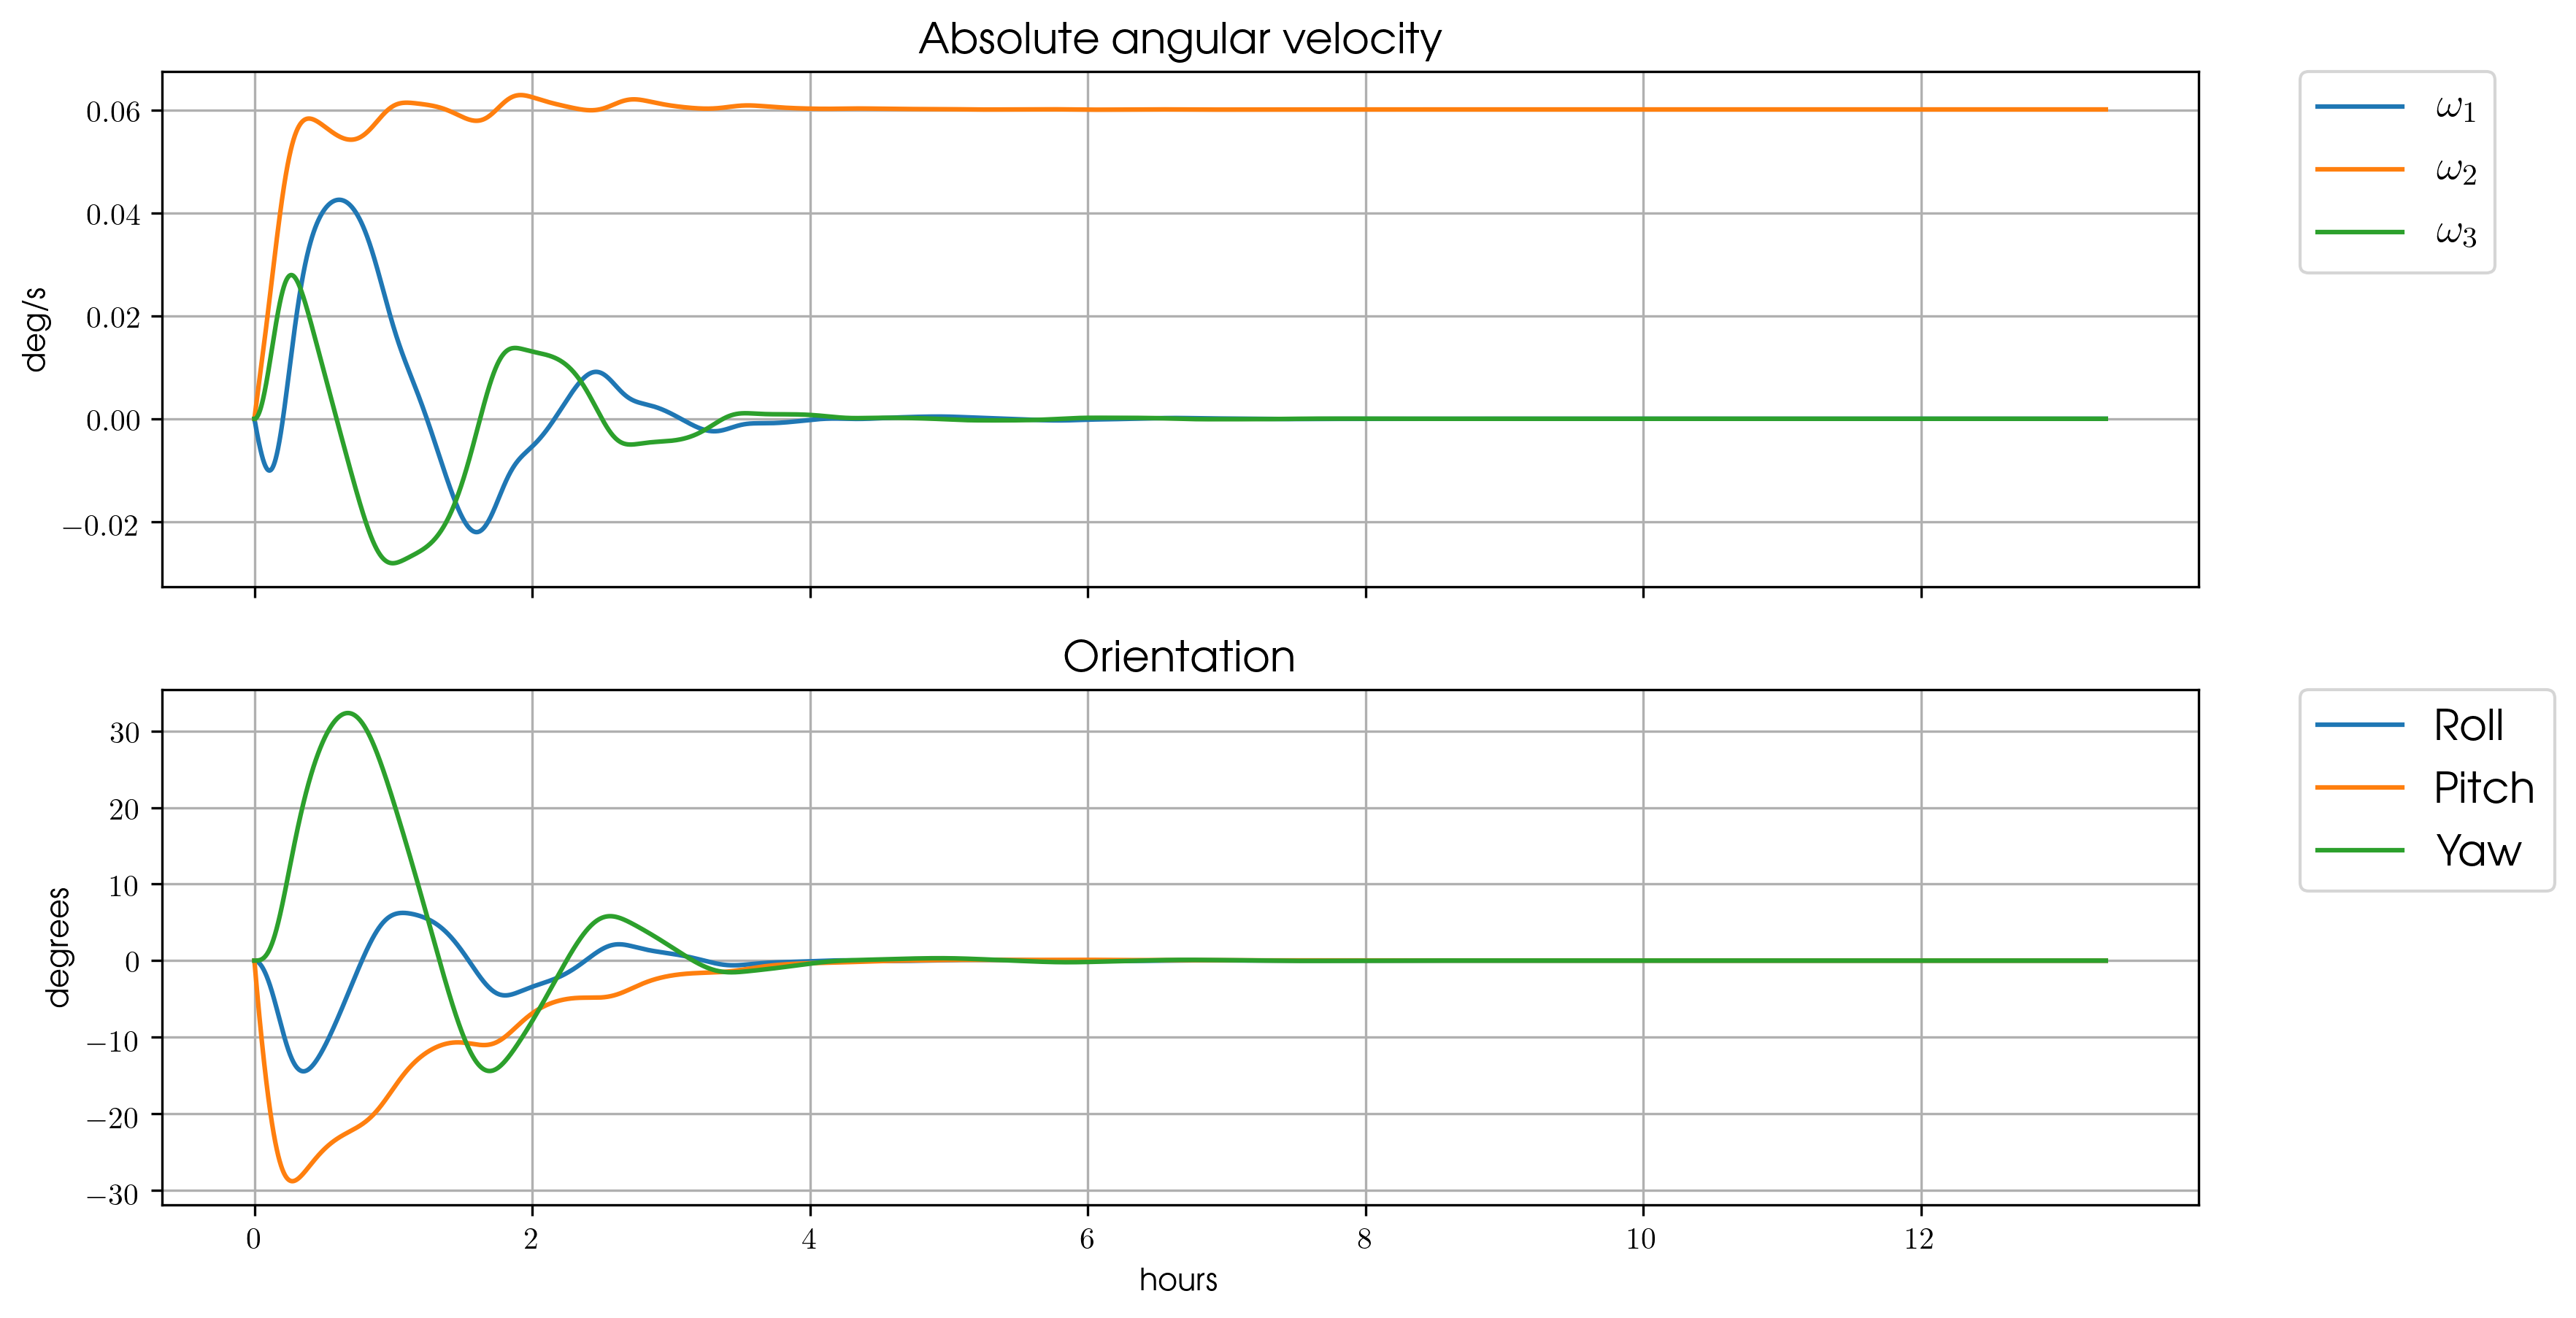

In [36]:
AAV = True
ZAAV = False
RAV = False
ZRAV = False
RPY = True
ZRPY = False
QUAT = False
ZQUAT = False
structure = [AAV, ZAAV, RAV, ZRAV, RPY, ZRPY, QUAT, ZQUAT]

AAV_limits = [-0.03, 0.03]
RAV_limits = [-0.01, 0.01]
RPY_limits = [-15, 15]
QUAT_limits = [-0.05, 0.05]
limits = [AAV_limits, RAV_limits, RPY_limits, QUAT_limits]

time_unit = 'hours'
angle_unit = 'degrees'

grid = True
save = False

plot(N, t_meas, t_ctrl, prop1, structure=structure, limits=limits,
     time_unit=time_unit, angle_unit=angle_unit, grid=grid, save=save)

# Filtering

In [37]:
def filtering(N, t_meas, t_ctrl, alt, incl, isIGRF, sigma_magn_env, B_bias, sigma_magn, sigma_sun_env, S_bias, sigma_sun,
              omega_bias, sigma_gyro, kw, Ks, m_max, J, T_stat, sigma_torque, sigma_q0, sigma_omega0, q0, omega0, JD_UTC_init):
    
    orb = create_circ_orbit(alt, incl)
    mf = create_mf(orb, sigma_magn_env, isIGRF)
    mm = create_mm(B_bias, sigma_magn)
    sv = create_sv(orb, sigma_sun_env)
    ss = create_ss(S_bias, sigma_sun)
    gyr = create_gyr(omega_bias, sigma_gyro)
    ctrl = create_ctrl(kw, Ks, m_max, orb)
    sat = create_satellite(J, T_stat, sigma_torque, ctrl, mm, ss, gyr)
    ekf = create_EKF(sigma_q0, sigma_omega0, sat)
    prop = create_prop(sat, mf, sv, ekf, q0, omega0, JD_UTC_init)
    
    for i in range(1, N):
        
        prop.solve_motion_equation(t_ctrl, True)
        prop.state_corr(t_ctrl+t_meas)
        prop.move(t_ctrl)
        
        prop.solve_motion_equation(t_meas, False)    
        prop.move(t_meas)
        
    return prop

In [38]:
alt = 750e+3
incl = np.pi / 3

isIGRF = False
sigma_magn_env = 1e-9
B_bias = np.zeros(3)
sigma_magn = 1e-9

sigma_sun_env = 1e-9
S_bias = np.zeros(3)
sigma_sun = 1e-7

omega_bias = np.zeros(3)
sigma_gyro = 1e-7

kw = 47
Ks = 11
m_max = 0.1
J = np.diag(np.array([0.011, 0.014, 0.009]))
T_stat = np.zeros(3)
sigma_torque = 5e-9

q0 = np.array([1, 0, 0, 0])
omega0 = np.array([0, 0, 0])
JD_UTC_init = 2458940.1933954097

N = 8000
t_meas = 1
t_ctrl = 5

sigma_q0 = 1
sigma_omega0 = np.pi / 18

prop1 = filtering(N, t_meas, t_ctrl, alt, incl, isIGRF, sigma_magn_env, B_bias, sigma_magn, sigma_sun_env, S_bias, sigma_sun,
                  omega_bias, sigma_gyro, kw, Ks, m_max, J, T_stat, sigma_torque, sigma_q0, sigma_omega0, q0, omega0,
                  JD_UTC_init)

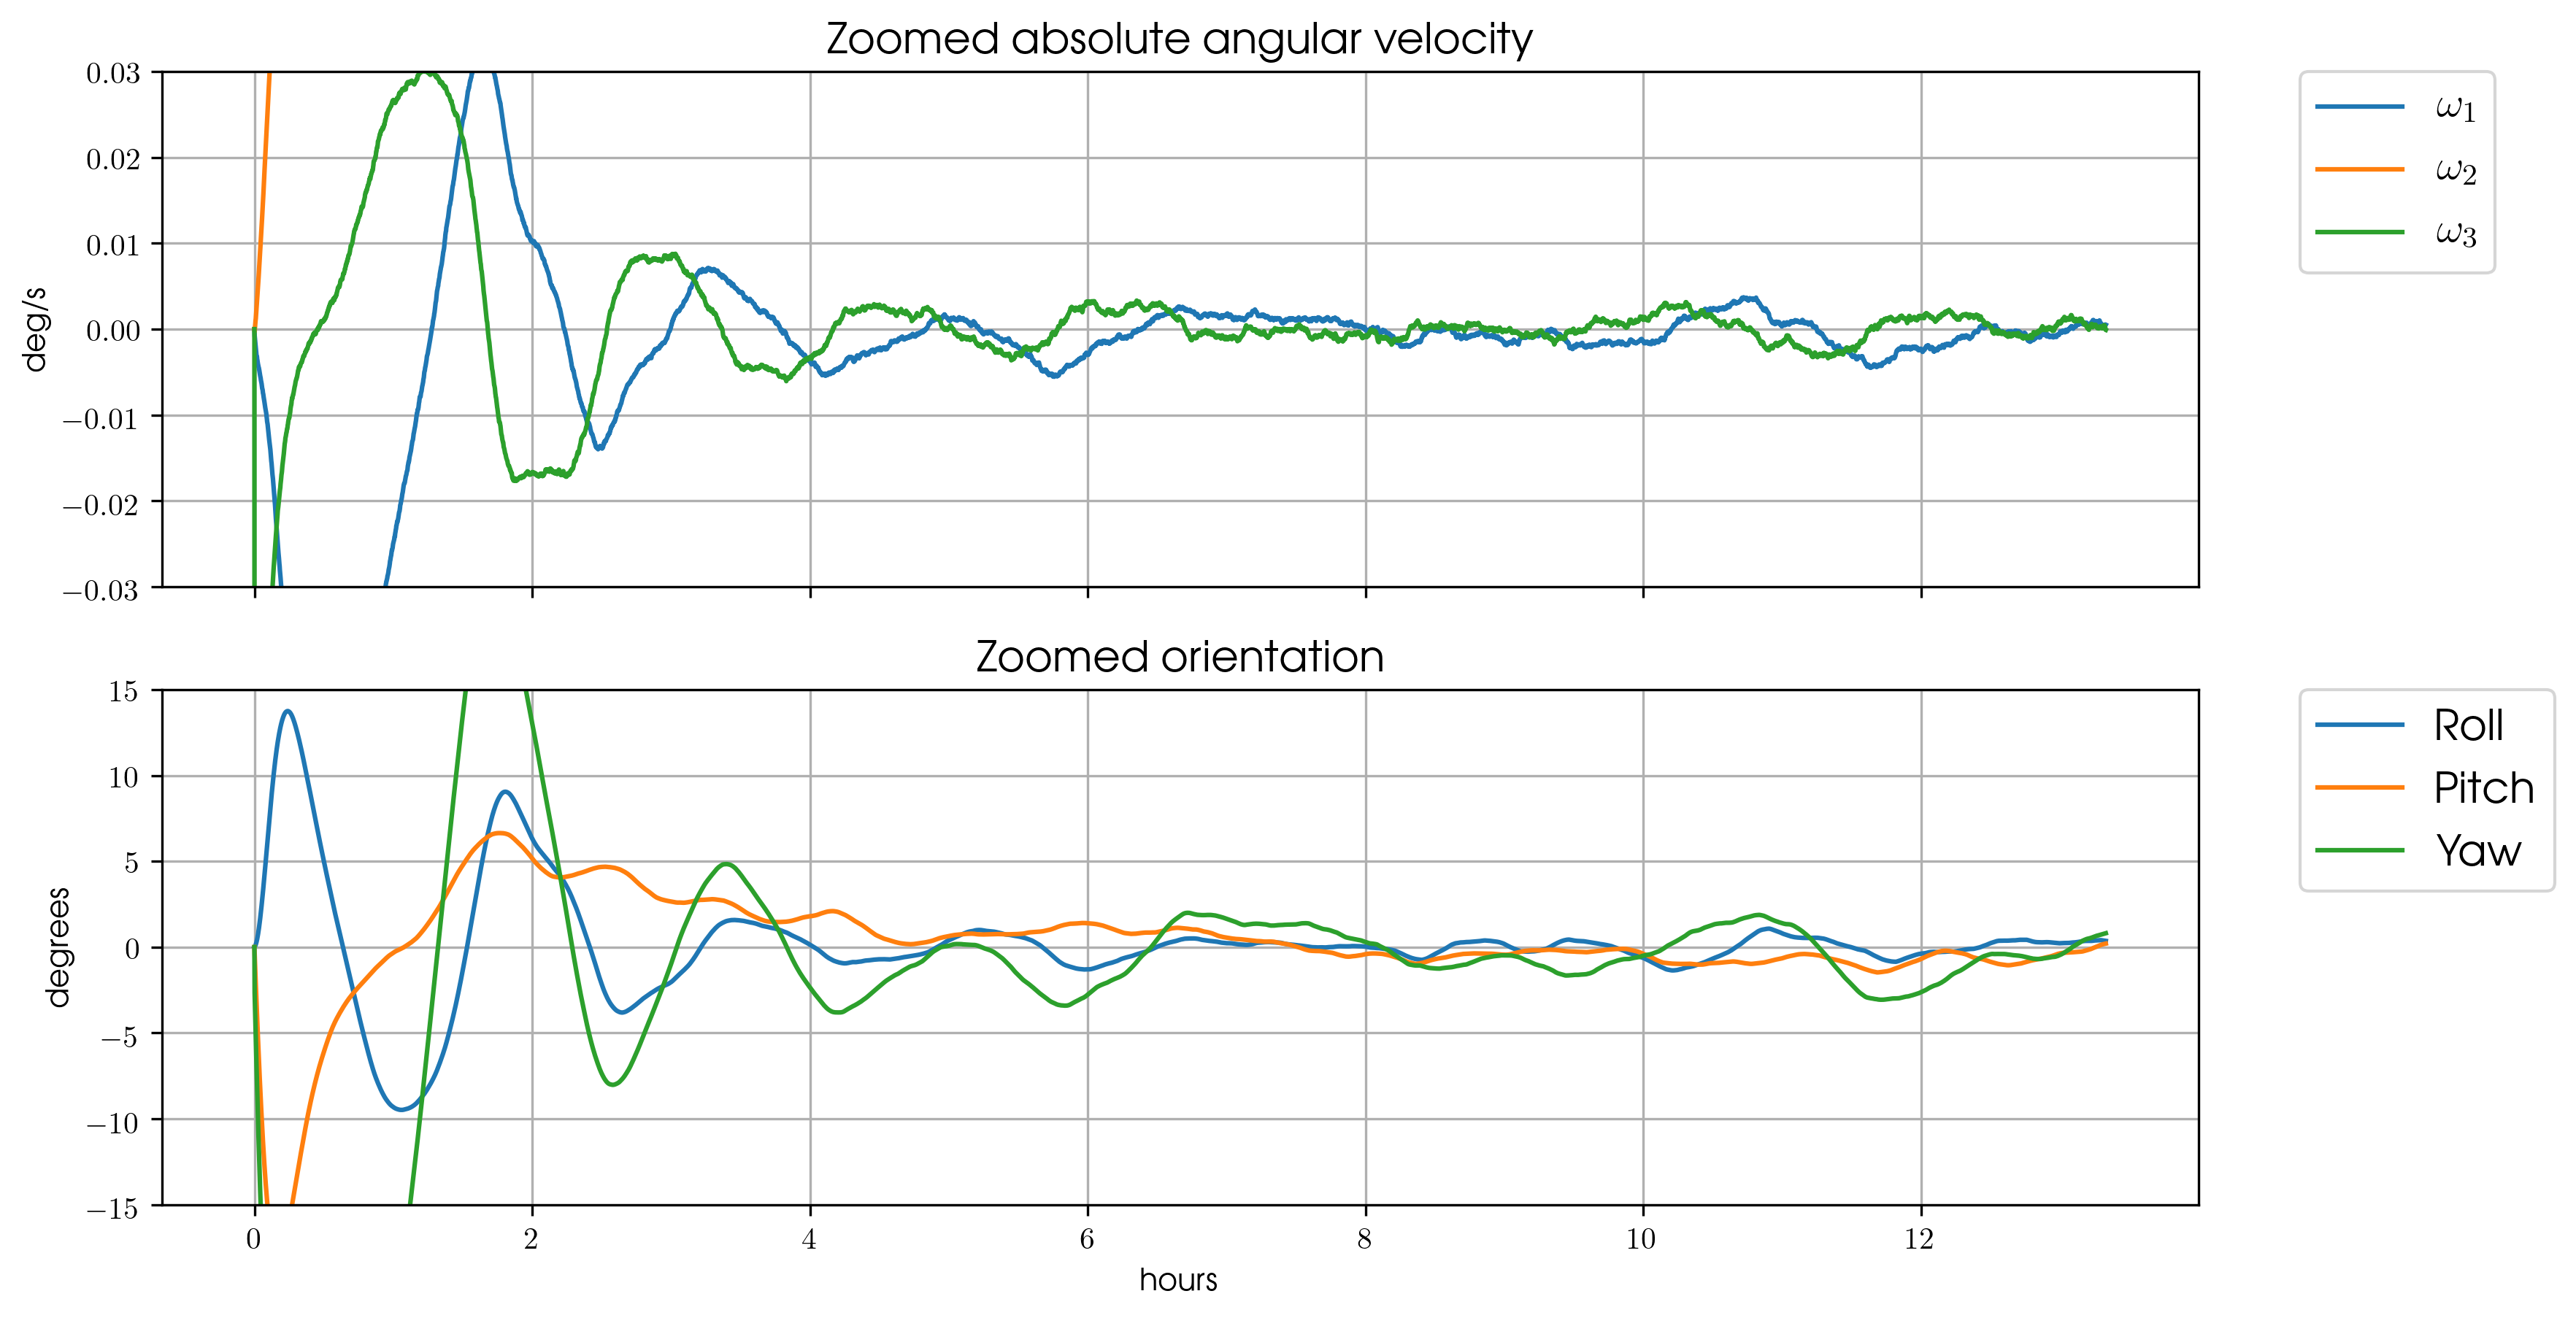

In [39]:
AAV = False
ZAAV = True
RAV = False
ZRAV = False
RPY = False
ZRPY = True
QUAT = False
ZQUAT = False
structure = [AAV, ZAAV, RAV, ZRAV, RPY, ZRPY, QUAT, ZQUAT]

AAV_limits = [-0.03, 0.03]
RAV_limits = [-0.01, 0.01]
RPY_limits = [-15, 15]
QUAT_limits = [-0.05, 0.05]
limits = [AAV_limits, RAV_limits, RPY_limits, QUAT_limits]

time_unit = 'hours'
angle_unit = 'degrees'

grid = True
save = False

plot(N, t_meas, t_ctrl, prop1, structure=structure, limits=limits,
     time_unit=time_unit, angle_unit=angle_unit, grid=grid, save=save)

# Mean-Squared Errors

In [40]:
@jit(nopython=True)
def abs_sqr(vec1, vec2, ret):
        
    ret += (vec1 - vec2)**2
    
@jit(nopython=True)
def sqrtM(vec, m):
        
    return np.sqrt(vec / m)

def mse(M, N, t_meas, t_ctrl, alt, incl, isIGRF, sigma_magn_env, B_bias, sigma_magn, sigma_sun_env, S_bias, sigma_sun,
        omega_bias, sigma_gyro, kw, Ks, m_max, J, T_stat, sigma_torque, sigma_q0, sigma_omega0, q0, omega0, JD_UTC_init):
    
    error_omega = np.zeros((3, N))
    error_Omega = np.zeros((3, N))
    error_angles = np.zeros((3, N))
    error_quat = np.zeros((4, N))
    
    prop_dynamics = dynamics(N, t_meas, t_ctrl, alt, incl, isIGRF, 0, np.zeros(3), 0, 0, np.zeros(3), 0, np.zeros(3), 0,
                             kw, Ks, m_max, J, np.zeros(3), 0, q0, omega0, JD_UTC_init)
    
    states_true = prop_dynamics.state_history
    quat_true = states_true[:4]
    omega_true = states_true[4:]
    
    angles_true = quat2rpy(quat_true)
    Omega_true = np.array(list(map(lambda q, o: prop_dynamics.omega_to_Omega(q, o), quat_true.T, omega_true.T))).T
    
    quat_true[0] = np.abs(quat_true[0])
    
    sum = M
    
    props = []
    
    for _ in range(M):
        
        prop = filtering(N, t_meas, t_ctrl, alt, incl, isIGRF, sigma_magn_env, B_bias, sigma_magn, sigma_sun_env, S_bias,
                         sigma_sun, omega_bias, sigma_gyro, kw, Ks, m_max, J, T_stat, sigma_torque, sigma_q0, sigma_omega0, q0,
                         omega0, JD_UTC_init)
        
        props.append(prop)
        
        states = prop.state_history
        quat = states[:4]
        omega = states[4:]
        
        if omega[1,-1] > 0:
        
            angles = quat2rpy(quat)
            Omega = np.array(list(map(lambda q, o: prop.omega_to_Omega(q, o), quat.T, omega.T))).T

            quat[0] = np.abs(quat[0])
            
            abs_sqr(omega, omega_true, error_omega)
            abs_sqr(Omega, Omega_true, error_Omega)
            abs_sqr(angles, angles_true, error_angles)
            abs_sqr(quat, quat_true, error_quat)
            
        else:
            
            sum -= 1
        
        print('\r', 'Finished {} iterations'.format(_+1), end='')
    
    error_omega = sqrtM(error_omega, sum)
    error_Omega = sqrtM(error_Omega, sum)
    error_angles = sqrtM(error_angles, sum)
    error_quat = sqrtM(error_quat, sum)
        
    return np.vstack((error_omega, error_Omega, error_angles, error_quat)), props

In [41]:
# alt = 750e+3
# incl = np.pi / 3

# isIGRF = True
# sigma_magn_env = 1e-9
# B_bias = np.zeros(3)
# sigma_magn = 1e-9

# sigma_sun_env = 1e-9
# S_bias = np.zeros(3)
# sigma_sun = 1e-5

# omega_bias = np.zeros(3)
# sigma_gyro = 1e-6

# kw = 47
# Ks = 11
# m_max = 0.1
# J = np.diag(np.array([0.011, 0.014, 0.009]))
# T_stat = np.zeros(3)
# sigma_torque = 5e-9

# q0 = np.array([1, 0, 0, 0])
# omega0 = np.array([0, 0, 0])
# JD_UTC_init = 2458940.1933954097

# N = 8000
# t_meas = 1
# t_ctrl = 5

# sigma_q0 = 1
# sigma_omega0 = np.pi / 18

# M = 10

# err, props = mse(M, N, t_meas, t_ctrl, alt, incl, isIGRF, sigma_magn_env, B_bias, sigma_magn, sigma_sun_env, S_bias, sigma_sun,
#                  omega_bias, sigma_gyro, kw, Ks, m_max, J, T_stat, sigma_torque, sigma_q0, sigma_omega0, q0, omega0,
#                  JD_UTC_init)

In [42]:
# AAV = False
# ZAAV = True
# RAV = False
# ZRAV = False
# RPY = False
# ZRPY = True
# QUAT = False
# ZQUAT = False
# structure = [AAV, ZAAV, RAV, ZRAV, RPY, ZRPY, QUAT, ZQUAT]

# AAV_limits = [0, 0.007]
# RAV_limits = [0, 0.01]
# RPY_limits = [0, 5]
# QUAT_limits = [0, 0.05]
# limits = [AAV_limits, RAV_limits, RPY_limits, QUAT_limits]

# time_unit = 'hours'
# angle_unit = 'degrees'

# grid = True
# save = False

# plot(N, t_meas, t_ctrl, err, structure=structure, limits=limits,
#      time_unit=time_unit, angle_unit=angle_unit, grid=grid, save=save)